In [8]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from keras.utils import to_categorical

import sys

import numpy as np

class GAN():
    
    def init_v17_v10_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V10'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
            
    def init_v17_v14_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V14'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
        
    def load_fraud_data(self):
        # Read in dataset from csv file
        data = pd.read_csv("creditcard.csv")
        
        # Take only the fraud examples
        data_fraud = data.loc[data['Class'] == 1]
        data_non_fraud = data.loc[data['Class'] == 0]
        
        # Remove class column as not needed, these are all Class=1
        data_fraud = data_fraud.loc[:, data_fraud.columns != 'Class']
        self.data_cols = data_fraud.columns
        
        data_non_fraud = data_non_fraud.loc[:, data_non_fraud.columns != 'Class']
        
        
        # Scale data using StandardScaler
        pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(data_fraud)
        data_fraud = preprocessor.transform(data_fraud)
        data_fraud = pd.DataFrame(data_fraud, columns=self.data_cols)
        
        self.data_fraud = data_fraud
        
        #non fraud
        preprocessor = pipeline.fit(data_non_fraud)
        data_non_fraud = preprocessor.transform(data_non_fraud)
        data_non_fraud = pd.DataFrame(data_non_fraud, columns=self.data_cols)
        
        self.data_non_fraud = data_non_fraud
        
    def load_raw_data(self):
        return pd.read_csv("creditcard.csv")
        
    def __init__(self):
        self.img_rows = 1 
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.00002, 0.5)
        
        # Load fraud data 
        self.load_fraud_data()
        self.data_raw = self.load_raw_data()
        
        # Initialise the data plot grid
#         self.init_v17_v10_plot()
        self.init_v17_v10_plot()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy','categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss=['binary_crossentropy'], optimizer=optimizer)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)
        
        from keras.utils.vis_utils import plot_model
        import pydot, graphviz
        plot_model(self.generator, to_file='ganv1-ssl-generator_plot.png', show_shapes=True, show_layer_names=True)
        plot_model(self.discriminator, to_file='ganv1-ssl-discriminator_plot.png', show_shapes=True, show_layer_names=True)
        plot_model(self.combined, to_file='ganv1-ssl-combined_plot.png', show_shapes=True, show_layer_names=True)

    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape))) # , activation='tanh'
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
#         model.add(Dense(2, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)
        

        valid = Dense(1, activation="sigmoid")(validity)
        label = Dense(2, activation="softmax")(validity)

        return Model(img, [valid, label])
#         return Model(img, label)
    
    def generate_train_test_sample(self, data, test_ratio=0.3): 
        
        # Assign variables x and y corresponding to row data and it's class value
        X = data.ix[:, data.columns != 'Class']
        y = data.ix[:, data.columns == 'Class']

        # performs random split (i.e random selects 70% datapoints)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)

        return X_train_prp, X_test_prp, y_train, y_test
    
    def generate_train_test_timeseries(data, test_ratio=0.3):

        total_samples = data.shape[0]

        cutoff = int(total_samples * (1 - test_ratio))

        data.sort_values('Time', inplace=True)

        X_train = data.loc[0:cutoff, data.columns != 'Class']
        y_train = data.loc[0:cutoff, data.columns == 'Class']
        X_test = data.loc[cutoff:, data.columns != 'Class']
        y_test = data.loc[cutoff:, data.columns == 'Class']

        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)



        return X_train_prp, y_train, X_test_prp, y_test
    

    def train(self, epochs, batch_size=128, save_interval=200):
        
        data_cols = self.data_cols
        # Load the dataset
        X_train_fraud = self.data_fraud.values
        X_train_non_fraud = self.data_non_fraud
#         X_train, X_test, y_train, y_test = self.generate_train_test_sample(self.data_raw)
        
        X_train_fraud = np.expand_dims(X_train_fraud, axis=3)
        X_train_fraud = np.expand_dims(X_train_fraud, axis=1)
#         y_train = np.expand_dims(y_train, axis=1)
        X_train_non_fraud = np.expand_dims(X_train_non_fraud, axis=3)
        X_train_non_fraud = np.expand_dims(X_train_non_fraud, axis=1)
        
        half_batch = int(batch_size / 2)
        self.losses = []
        
        cw1 = {0: 1, 1: 1}
        cw2 = {i: 2 / half_batch for i in range(2)}
        cw2[2] = 1 / half_batch
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx_fraud = np.random.randint(0, X_train_fraud.shape[0], int(half_batch /2))
            idx_non_fraud = np.random.randint(0, X_train_non_fraud.shape[0], int(half_batch /2))
                                              
            imgs_fraud = X_train_fraud[idx_fraud]
            imgs_non_fraud = X_train_non_fraud[idx_non_fraud]
                                              
            imgs_ys_fraud = [1 for i in idx_fraud]
            imgs_ys_non_fraud = [0 for i in idx_non_fraud]
                                              
            imgs_ys = imgs_ys_fraud+imgs_ys_non_fraud
            
            imgs = np.concatenate((imgs_fraud, imgs_non_fraud))
            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)
            
            self.discriminator.trainable = True
            # Train the discriminator
#             X = np.concatenate((imgs,gen_imgs))
#             y = np.zeros([len(imgs)+len(gen_imgs),3])
#             y[0:len(imgs),2] = [i[0][0] for i in imgs_ys]
#             y[0:len(imgs),1] = 1
#             y[len(imgs):,0] = 1

#             labels = np.zeros([len(imgs)+len(gen_imgs),2])
#             labels[0:len(imgs),1] = 1
#             labels[len(imgs):,0] = 1
            
            valid = np.ones((half_batch, 1))
            fake = np.zeros((half_batch, 1))
            
#             labels = np.full((2*half_batch,3),0)
            labels = to_categorical(imgs_ys, num_classes=2)
        
            fake_labels = to_categorical(np.full((half_batch, 1), 1), num_classes=2)
            
#             d_loss = self.discriminator.train_on_batch(X, y)
#             d_loss = [0.5 * (i+j) for i,j in (d_loss_real, d_loss_fake)]
#             d_loss = 0.5*(d_loss_real[0]+d_loss_fake[0])
#             d_acc = 0.5*(d_loss_real[1]+d_loss_fake[1])

            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            self.discriminator.trainable = False

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
#             valid_y = np.array([1] * batch_size)
#             valid_y = np.zeros([batch_size,2])
#             valid_y[:,1] = 1

            valid_y = np.ones((batch_size, 1))
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y, class_weight=[cw1, cw2])
            
            self.losses.append((d_loss, g_loss))

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, imgs, gen_imgs)
                
        self.save_loss_plot()
        
    def save_loss_plot(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot([i[0][0] for i in losses], label='Discriminator')
        plt.plot([i[1] for i in losses], label='Generator')
        plt.title("Training Losses")
        plt.legend()
        
        fig.savefig("GANv1-ssl-losses-halfandhalf.png")
        plt.close()
        
    def save_imgs(self, epoch, img, gen_imgs):

        col1, col2 = 'V17', 'V10'
        noise = np.random.normal(0, 1, (492, 100))

            # Generate a half batch of new images
        gen_imgs = self.generator.predict(noise)

        gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[2])
        gen_samples = pd.DataFrame(gen_imgs, columns=self.data_cols)
        
        gen_samples.plot(kind='scatter', ax=self.axes[self.plot_counter,1], x = col1, y = col2)
        self.plot_counter = self.plot_counter +1
        
        if self.plot_counter == 6:
            self.fig.tight_layout()
            self.fig.savefig("GANv1-ssl-v17-v10-halfandhalf.png")
            plt.close()
            
    
    def test_as_classifier(self):
        from sklearn.metrics import confusion_matrix, classification_report
        
        data_raw = pd.read_csv("creditcard.csv")
    
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(data_raw)
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)
        y_train = np.expand_dims(y_train, axis=1)
#         y_test = np.expand_dims(y_test, axis=1)
        X_test = np.expand_dims(X_test, axis=3)
        X_test = np.expand_dims(X_test, axis=1)
        
        output = self.discriminator.predict(X_test)

        cutt_off_tr = 0.5
#         return y_pred
        y_pred = output[1]
        print(y_pred)
#         print(max(y_pred[:,0]),max(y_pred[:,1]),max(y_pred[:,2]))
#         fraud_indexes = y_test.values[np.where(y_test.values[:]=1]
        indices = [i for i, x in enumerate(y_test.values) if x == 1]
        y_score = np.full((y_pred.shape[0],1),0)
        y_score[np.where(y_pred[:,1]>=cutt_off_tr)] = 1
        y_score[np.where(y_pred[:,1]<cutt_off_tr)]  = 0
        print(y_score)
        print(y_test)
        print(1 in y_test.values)
        print(y_pred[indices])
        prfs = precision_recall_fscore_support(y_test, y_score, labels=[1])
        prfs0 = precision_recall_fscore_support(y_test, y_score, labels=[0])
        
        print(prfs)
        print(prfs0)
        
        print(classification_report(
        y_test,
        y_score,
        target_names = ["Genuine", "Fraud"],
        digits = 5))
        
        print (confusion_matrix(
        y_test,
        y_score))
        
        from sklearn.metrics import roc_curve, auc, roc_auc_score

        # short way
        print(roc_auc_score(y_test, y_score))
        return output



    

In [7]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6000, batch_size=32, save_interval=1000)
    gan.test_as_classifier()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
Total params: 147,200
Trainable params: 147,200
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:235: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:238: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.354353, acc.: 61.89%] [G loss: 0.452151]
1 [D loss: 0.364707, acc.: 64.46%] [G loss: 0.440173]
2 [D loss: 0.374060, acc.: 65.12%] [G loss: 0.438476]
3 [D loss: 0.361026, acc.: 63.81%] [G loss: 0.442778]
4 [D loss: 0.382656, acc.: 68.10%] [G loss: 0.434941]
5 [D loss: 0.383738, acc.: 66.07%] [G loss: 0.420321]
6 [D loss: 0.389781, acc.: 69.95%] [G loss: 0.436409]
7 [D loss: 0.388296, acc.: 70.05%] [G loss: 0.445972]
8 [D loss: 0.383600, acc.: 68.84%] [G loss: 0.417544]
9 [D loss: 0.395158, acc.: 71.65%] [G loss: 0.458177]
10 [D loss: 0.408369, acc.: 73.86%] [G loss: 0.435636]
11 [D loss: 0.419466, acc.: 76.51%] [G loss: 0.436398]
12 [D loss: 0.457110, acc.: 83.32%] [G loss: 0.460252]
13 [D loss: 0.422870, acc.: 76.56%] [G loss: 0.469807]
14 [D loss: 0.435454, acc.: 79.39%] [G loss: 0.457761]
15 [D loss: 0.440678, acc.: 80.59%] [G loss: 0.454940]
16 [D loss: 0.419515, acc.: 76.40%] [G loss: 0.472900]
17 [D loss: 0.421997, acc.: 77.14%] [G loss: 0.449813]
18 [D loss: 0.436472

149 [D loss: 0.384607, acc.: 70.65%] [G loss: 0.927058]
150 [D loss: 0.390204, acc.: 71.91%] [G loss: 0.923302]
151 [D loss: 0.391116, acc.: 70.60%] [G loss: 0.916320]
152 [D loss: 0.387923, acc.: 71.05%] [G loss: 0.927660]
153 [D loss: 0.383100, acc.: 70.06%] [G loss: 0.924484]
154 [D loss: 0.357122, acc.: 64.91%] [G loss: 0.941748]
155 [D loss: 0.390491, acc.: 71.43%] [G loss: 0.911519]
156 [D loss: 0.384610, acc.: 70.46%] [G loss: 0.933447]
157 [D loss: 0.364087, acc.: 66.81%] [G loss: 0.922317]
158 [D loss: 0.375977, acc.: 69.06%] [G loss: 0.927644]
159 [D loss: 0.367892, acc.: 66.99%] [G loss: 0.917780]
160 [D loss: 0.393124, acc.: 71.70%] [G loss: 0.932990]
161 [D loss: 0.376881, acc.: 69.20%] [G loss: 0.925602]
162 [D loss: 0.378090, acc.: 69.72%] [G loss: 0.926273]
163 [D loss: 0.361331, acc.: 66.17%] [G loss: 0.945686]
164 [D loss: 0.395198, acc.: 72.41%] [G loss: 0.918509]
165 [D loss: 0.372270, acc.: 68.56%] [G loss: 0.940806]
166 [D loss: 0.371915, acc.: 68.53%] [G loss: 0.

299 [D loss: 0.377417, acc.: 69.57%] [G loss: 0.889500]
300 [D loss: 0.382856, acc.: 70.41%] [G loss: 0.881344]
301 [D loss: 0.391206, acc.: 71.80%] [G loss: 0.888150]
302 [D loss: 0.374391, acc.: 68.71%] [G loss: 0.882129]
303 [D loss: 0.383996, acc.: 70.34%] [G loss: 0.902700]
304 [D loss: 0.379161, acc.: 69.63%] [G loss: 0.878980]
305 [D loss: 0.376515, acc.: 68.84%] [G loss: 0.880560]
306 [D loss: 0.377818, acc.: 69.82%] [G loss: 0.890075]
307 [D loss: 0.385880, acc.: 70.84%] [G loss: 0.883528]
308 [D loss: 0.386905, acc.: 71.34%] [G loss: 0.917478]
309 [D loss: 0.384196, acc.: 70.39%] [G loss: 0.875944]
310 [D loss: 0.385215, acc.: 70.86%] [G loss: 0.899379]
311 [D loss: 0.406960, acc.: 74.83%] [G loss: 0.896123]
312 [D loss: 0.390582, acc.: 71.43%] [G loss: 0.910349]
313 [D loss: 0.388683, acc.: 71.13%] [G loss: 0.903877]
314 [D loss: 0.390490, acc.: 71.79%] [G loss: 0.910380]
315 [D loss: 0.373172, acc.: 68.33%] [G loss: 0.938872]
316 [D loss: 0.374589, acc.: 69.38%] [G loss: 0.

449 [D loss: 0.368829, acc.: 67.53%] [G loss: 0.856144]
450 [D loss: 0.387151, acc.: 70.56%] [G loss: 0.868700]
451 [D loss: 0.369172, acc.: 67.93%] [G loss: 0.853312]
452 [D loss: 0.373011, acc.: 68.52%] [G loss: 0.839692]
453 [D loss: 0.370410, acc.: 68.73%] [G loss: 0.857711]
454 [D loss: 0.390396, acc.: 71.21%] [G loss: 0.862894]
455 [D loss: 0.373753, acc.: 68.33%] [G loss: 0.850628]
456 [D loss: 0.370880, acc.: 68.22%] [G loss: 0.855659]
457 [D loss: 0.389956, acc.: 70.52%] [G loss: 0.859914]
458 [D loss: 0.375868, acc.: 69.36%] [G loss: 0.843791]
459 [D loss: 0.364363, acc.: 67.04%] [G loss: 0.839452]
460 [D loss: 0.368183, acc.: 67.25%] [G loss: 0.846615]
461 [D loss: 0.374723, acc.: 69.06%] [G loss: 0.859213]
462 [D loss: 0.380277, acc.: 69.49%] [G loss: 0.847516]
463 [D loss: 0.369446, acc.: 67.87%] [G loss: 0.837439]
464 [D loss: 0.378089, acc.: 68.80%] [G loss: 0.831442]
465 [D loss: 0.365647, acc.: 66.85%] [G loss: 0.851915]
466 [D loss: 0.371046, acc.: 68.17%] [G loss: 0.

601 [D loss: 0.374183, acc.: 68.62%] [G loss: 0.773393]
602 [D loss: 0.385539, acc.: 70.31%] [G loss: 0.772100]
603 [D loss: 0.369997, acc.: 68.07%] [G loss: 0.780476]
604 [D loss: 0.379447, acc.: 68.92%] [G loss: 0.771687]
605 [D loss: 0.371240, acc.: 68.26%] [G loss: 0.780079]
606 [D loss: 0.376886, acc.: 69.12%] [G loss: 0.769869]
607 [D loss: 0.370900, acc.: 67.80%] [G loss: 0.781132]
608 [D loss: 0.375688, acc.: 68.78%] [G loss: 0.767330]
609 [D loss: 0.387073, acc.: 69.99%] [G loss: 0.773102]
610 [D loss: 0.383337, acc.: 70.38%] [G loss: 0.771710]
611 [D loss: 0.361699, acc.: 66.46%] [G loss: 0.762645]
612 [D loss: 0.384485, acc.: 68.99%] [G loss: 0.776631]
613 [D loss: 0.365092, acc.: 67.34%] [G loss: 0.768259]
614 [D loss: 0.371181, acc.: 67.95%] [G loss: 0.768298]
615 [D loss: 0.370927, acc.: 67.96%] [G loss: 0.776416]
616 [D loss: 0.375673, acc.: 68.71%] [G loss: 0.772810]
617 [D loss: 0.370938, acc.: 68.25%] [G loss: 0.755301]
618 [D loss: 0.364234, acc.: 67.00%] [G loss: 0.

749 [D loss: 0.385472, acc.: 69.97%] [G loss: 0.777844]
750 [D loss: 0.375069, acc.: 68.91%] [G loss: 0.768372]
751 [D loss: 0.374876, acc.: 68.36%] [G loss: 0.772815]
752 [D loss: 0.377872, acc.: 68.69%] [G loss: 0.786221]
753 [D loss: 0.366870, acc.: 67.84%] [G loss: 0.778812]
754 [D loss: 0.371192, acc.: 68.27%] [G loss: 0.774281]
755 [D loss: 0.360607, acc.: 66.03%] [G loss: 0.786673]
756 [D loss: 0.372929, acc.: 67.63%] [G loss: 0.772644]
757 [D loss: 0.369563, acc.: 67.70%] [G loss: 0.770066]
758 [D loss: 0.380019, acc.: 69.39%] [G loss: 0.768162]
759 [D loss: 0.375859, acc.: 68.96%] [G loss: 0.774416]
760 [D loss: 0.370911, acc.: 67.64%] [G loss: 0.775051]
761 [D loss: 0.368636, acc.: 67.54%] [G loss: 0.767120]
762 [D loss: 0.368904, acc.: 67.82%] [G loss: 0.767631]
763 [D loss: 0.369176, acc.: 67.39%] [G loss: 0.769127]
764 [D loss: 0.363067, acc.: 66.47%] [G loss: 0.767589]
765 [D loss: 0.370660, acc.: 67.88%] [G loss: 0.770892]
766 [D loss: 0.376877, acc.: 69.36%] [G loss: 0.

900 [D loss: 0.376516, acc.: 68.75%] [G loss: 0.751501]
901 [D loss: 0.365019, acc.: 67.02%] [G loss: 0.739655]
902 [D loss: 0.389551, acc.: 72.35%] [G loss: 0.745157]
903 [D loss: 0.364157, acc.: 66.74%] [G loss: 0.751602]
904 [D loss: 0.387373, acc.: 71.14%] [G loss: 0.739290]
905 [D loss: 0.377973, acc.: 69.41%] [G loss: 0.746239]
906 [D loss: 0.375339, acc.: 68.90%] [G loss: 0.740632]
907 [D loss: 0.374634, acc.: 68.66%] [G loss: 0.746676]
908 [D loss: 0.372333, acc.: 68.40%] [G loss: 0.749514]
909 [D loss: 0.369469, acc.: 67.89%] [G loss: 0.749861]
910 [D loss: 0.378520, acc.: 69.28%] [G loss: 0.741654]
911 [D loss: 0.368900, acc.: 66.68%] [G loss: 0.752043]
912 [D loss: 0.369239, acc.: 67.52%] [G loss: 0.752459]
913 [D loss: 0.374152, acc.: 68.74%] [G loss: 0.755562]
914 [D loss: 0.363790, acc.: 66.78%] [G loss: 0.746920]
915 [D loss: 0.367962, acc.: 67.61%] [G loss: 0.748705]
916 [D loss: 0.372499, acc.: 68.60%] [G loss: 0.749910]
917 [D loss: 0.393082, acc.: 71.88%] [G loss: 0.

1048 [D loss: 0.367486, acc.: 67.45%] [G loss: 0.743343]
1049 [D loss: 0.365129, acc.: 67.42%] [G loss: 0.738868]
1050 [D loss: 0.375519, acc.: 69.19%] [G loss: 0.741679]
1051 [D loss: 0.376296, acc.: 68.89%] [G loss: 0.741134]
1052 [D loss: 0.361638, acc.: 66.54%] [G loss: 0.732641]
1053 [D loss: 0.367965, acc.: 66.90%] [G loss: 0.739743]
1054 [D loss: 0.377180, acc.: 69.54%] [G loss: 0.746419]
1055 [D loss: 0.368009, acc.: 67.58%] [G loss: 0.737681]
1056 [D loss: 0.374091, acc.: 68.36%] [G loss: 0.737799]
1057 [D loss: 0.379523, acc.: 69.52%] [G loss: 0.740244]
1058 [D loss: 0.372748, acc.: 67.91%] [G loss: 0.738688]
1059 [D loss: 0.367998, acc.: 67.81%] [G loss: 0.736178]
1060 [D loss: 0.372350, acc.: 67.47%] [G loss: 0.745756]
1061 [D loss: 0.356499, acc.: 65.49%] [G loss: 0.742361]
1062 [D loss: 0.364155, acc.: 66.71%] [G loss: 0.737239]
1063 [D loss: 0.374420, acc.: 68.46%] [G loss: 0.743357]
1064 [D loss: 0.368199, acc.: 67.98%] [G loss: 0.735441]
1065 [D loss: 0.369756, acc.: 6

1195 [D loss: 0.395710, acc.: 70.12%] [G loss: 0.712773]
1196 [D loss: 0.367307, acc.: 67.12%] [G loss: 0.706583]
1197 [D loss: 0.374757, acc.: 69.07%] [G loss: 0.718163]
1198 [D loss: 0.364831, acc.: 66.94%] [G loss: 0.714599]
1199 [D loss: 0.384111, acc.: 70.10%] [G loss: 0.701560]
1200 [D loss: 0.376914, acc.: 68.94%] [G loss: 0.707773]
1201 [D loss: 0.379706, acc.: 69.77%] [G loss: 0.711003]
1202 [D loss: 0.376309, acc.: 68.11%] [G loss: 0.722737]
1203 [D loss: 0.368894, acc.: 67.75%] [G loss: 0.707807]
1204 [D loss: 0.376711, acc.: 68.43%] [G loss: 0.709935]
1205 [D loss: 0.369196, acc.: 67.73%] [G loss: 0.712247]
1206 [D loss: 0.368501, acc.: 67.75%] [G loss: 0.713257]
1207 [D loss: 0.380126, acc.: 68.99%] [G loss: 0.708297]
1208 [D loss: 0.363158, acc.: 66.84%] [G loss: 0.709923]
1209 [D loss: 0.368564, acc.: 67.65%] [G loss: 0.712187]
1210 [D loss: 0.373400, acc.: 68.41%] [G loss: 0.709970]
1211 [D loss: 0.366398, acc.: 67.15%] [G loss: 0.721168]
1212 [D loss: 0.370851, acc.: 6

1341 [D loss: 0.367837, acc.: 67.62%] [G loss: 0.715827]
1342 [D loss: 0.370675, acc.: 67.94%] [G loss: 0.708136]
1343 [D loss: 0.365531, acc.: 66.81%] [G loss: 0.705056]
1344 [D loss: 0.369048, acc.: 68.11%] [G loss: 0.716594]
1345 [D loss: 0.366904, acc.: 67.24%] [G loss: 0.713493]
1346 [D loss: 0.370062, acc.: 67.52%] [G loss: 0.703919]
1347 [D loss: 0.430233, acc.: 76.97%] [G loss: 0.697847]
1348 [D loss: 0.365740, acc.: 67.66%] [G loss: 0.716809]
1349 [D loss: 0.366776, acc.: 67.42%] [G loss: 0.714824]
1350 [D loss: 0.361625, acc.: 66.78%] [G loss: 0.704347]
1351 [D loss: 0.373489, acc.: 68.19%] [G loss: 0.706528]
1352 [D loss: 0.370320, acc.: 67.50%] [G loss: 0.704997]
1353 [D loss: 0.370600, acc.: 68.04%] [G loss: 0.703563]
1354 [D loss: 0.365857, acc.: 67.08%] [G loss: 0.712202]
1355 [D loss: 0.362712, acc.: 66.54%] [G loss: 0.694209]
1356 [D loss: 0.372573, acc.: 68.40%] [G loss: 0.707398]
1357 [D loss: 0.373150, acc.: 68.43%] [G loss: 0.709708]
1358 [D loss: 0.375386, acc.: 6

1490 [D loss: 0.370450, acc.: 68.44%] [G loss: 0.732349]
1491 [D loss: 0.349841, acc.: 64.43%] [G loss: 0.738277]
1492 [D loss: 0.366144, acc.: 67.67%] [G loss: 0.732168]
1493 [D loss: 0.372673, acc.: 69.15%] [G loss: 0.737180]
1494 [D loss: 0.377270, acc.: 69.39%] [G loss: 0.742744]
1495 [D loss: 0.379979, acc.: 69.48%] [G loss: 0.733554]
1496 [D loss: 0.364242, acc.: 66.96%] [G loss: 0.730541]
1497 [D loss: 0.358252, acc.: 65.95%] [G loss: 0.737808]
1498 [D loss: 0.363853, acc.: 67.12%] [G loss: 0.741689]
1499 [D loss: 0.359514, acc.: 65.84%] [G loss: 0.742395]
1500 [D loss: 0.368512, acc.: 67.73%] [G loss: 0.739736]
1501 [D loss: 0.369413, acc.: 67.95%] [G loss: 0.742874]
1502 [D loss: 0.364590, acc.: 67.08%] [G loss: 0.737091]
1503 [D loss: 0.363355, acc.: 66.88%] [G loss: 0.748326]
1504 [D loss: 0.363704, acc.: 67.07%] [G loss: 0.729159]
1505 [D loss: 0.378272, acc.: 69.52%] [G loss: 0.742478]
1506 [D loss: 0.373848, acc.: 69.21%] [G loss: 0.736484]
1507 [D loss: 0.384544, acc.: 6

1637 [D loss: 0.367246, acc.: 67.97%] [G loss: 0.713857]
1638 [D loss: 0.362924, acc.: 66.79%] [G loss: 0.717118]
1639 [D loss: 0.375217, acc.: 68.91%] [G loss: 0.726754]
1640 [D loss: 0.370347, acc.: 67.08%] [G loss: 0.713811]
1641 [D loss: 0.374856, acc.: 69.22%] [G loss: 0.719116]
1642 [D loss: 0.366639, acc.: 67.66%] [G loss: 0.721270]
1643 [D loss: 0.355126, acc.: 65.07%] [G loss: 0.710742]
1644 [D loss: 0.371536, acc.: 67.96%] [G loss: 0.715447]
1645 [D loss: 0.366130, acc.: 67.04%] [G loss: 0.716867]
1646 [D loss: 0.364895, acc.: 66.68%] [G loss: 0.710674]
1647 [D loss: 0.358063, acc.: 66.28%] [G loss: 0.720051]
1648 [D loss: 0.365512, acc.: 67.43%] [G loss: 0.710805]
1649 [D loss: 0.368329, acc.: 67.91%] [G loss: 0.720189]
1650 [D loss: 0.368605, acc.: 67.89%] [G loss: 0.708992]
1651 [D loss: 0.363236, acc.: 67.15%] [G loss: 0.718143]
1652 [D loss: 0.367904, acc.: 68.01%] [G loss: 0.715342]
1653 [D loss: 0.360910, acc.: 66.38%] [G loss: 0.719857]
1654 [D loss: 0.355273, acc.: 6

1784 [D loss: 0.364722, acc.: 66.98%] [G loss: 0.712842]
1785 [D loss: 0.365239, acc.: 67.42%] [G loss: 0.712941]
1786 [D loss: 0.371582, acc.: 68.44%] [G loss: 0.712815]
1787 [D loss: 0.348003, acc.: 63.58%] [G loss: 0.700722]
1788 [D loss: 0.370121, acc.: 67.17%] [G loss: 0.704218]
1789 [D loss: 0.371627, acc.: 68.54%] [G loss: 0.704974]
1790 [D loss: 0.366914, acc.: 67.45%] [G loss: 0.705503]
1791 [D loss: 0.371808, acc.: 67.00%] [G loss: 0.710750]
1792 [D loss: 0.364010, acc.: 67.05%] [G loss: 0.706312]
1793 [D loss: 0.369178, acc.: 68.08%] [G loss: 0.703606]
1794 [D loss: 0.367087, acc.: 67.01%] [G loss: 0.700035]
1795 [D loss: 0.362549, acc.: 66.49%] [G loss: 0.704889]
1796 [D loss: 0.360278, acc.: 66.11%] [G loss: 0.712529]
1797 [D loss: 0.367188, acc.: 67.47%] [G loss: 0.700609]
1798 [D loss: 0.358326, acc.: 65.92%] [G loss: 0.713099]
1799 [D loss: 0.382480, acc.: 69.35%] [G loss: 0.704461]
1800 [D loss: 0.364764, acc.: 66.68%] [G loss: 0.712119]
1801 [D loss: 0.364133, acc.: 6

1928 [D loss: 0.361399, acc.: 67.03%] [G loss: 0.712808]
1929 [D loss: 0.361465, acc.: 66.75%] [G loss: 0.706470]
1930 [D loss: 0.362001, acc.: 66.83%] [G loss: 0.719286]
1931 [D loss: 0.364093, acc.: 67.02%] [G loss: 0.710991]
1932 [D loss: 0.365059, acc.: 67.65%] [G loss: 0.713656]
1933 [D loss: 0.368181, acc.: 68.03%] [G loss: 0.709260]
1934 [D loss: 0.365093, acc.: 67.61%] [G loss: 0.716848]
1935 [D loss: 0.369939, acc.: 68.29%] [G loss: 0.715106]
1936 [D loss: 0.360588, acc.: 67.15%] [G loss: 0.715649]
1937 [D loss: 0.363759, acc.: 67.45%] [G loss: 0.722437]
1938 [D loss: 0.356089, acc.: 66.10%] [G loss: 0.711674]
1939 [D loss: 0.361119, acc.: 66.79%] [G loss: 0.723867]
1940 [D loss: 0.362379, acc.: 66.86%] [G loss: 0.715448]
1941 [D loss: 0.362853, acc.: 67.51%] [G loss: 0.720265]
1942 [D loss: 0.370169, acc.: 68.36%] [G loss: 0.710961]
1943 [D loss: 0.351787, acc.: 64.92%] [G loss: 0.724131]
1944 [D loss: 0.360105, acc.: 66.38%] [G loss: 0.710719]
1945 [D loss: 0.354488, acc.: 6

2075 [D loss: 0.362352, acc.: 66.73%] [G loss: 0.732880]
2076 [D loss: 0.344844, acc.: 63.30%] [G loss: 0.734632]
2077 [D loss: 0.358784, acc.: 67.01%] [G loss: 0.727553]
2078 [D loss: 0.363341, acc.: 67.18%] [G loss: 0.737745]
2079 [D loss: 0.363298, acc.: 67.41%] [G loss: 0.735418]
2080 [D loss: 0.366514, acc.: 68.05%] [G loss: 0.726225]
2081 [D loss: 0.353981, acc.: 65.19%] [G loss: 0.727490]
2082 [D loss: 0.366815, acc.: 67.81%] [G loss: 0.721325]
2083 [D loss: 0.376338, acc.: 68.51%] [G loss: 0.728807]
2084 [D loss: 0.362788, acc.: 67.01%] [G loss: 0.720580]
2085 [D loss: 0.366642, acc.: 67.54%] [G loss: 0.724620]
2086 [D loss: 0.366054, acc.: 67.88%] [G loss: 0.726715]
2087 [D loss: 0.367279, acc.: 68.39%] [G loss: 0.728086]
2088 [D loss: 0.366676, acc.: 67.93%] [G loss: 0.715244]
2089 [D loss: 0.360165, acc.: 66.22%] [G loss: 0.729028]
2090 [D loss: 0.367948, acc.: 68.38%] [G loss: 0.724274]
2091 [D loss: 0.359928, acc.: 66.93%] [G loss: 0.719244]
2092 [D loss: 0.371896, acc.: 6

2223 [D loss: 0.366307, acc.: 67.99%] [G loss: 0.688836]
2224 [D loss: 0.367603, acc.: 67.68%] [G loss: 0.692873]
2225 [D loss: 0.392946, acc.: 70.18%] [G loss: 0.698758]
2226 [D loss: 0.358646, acc.: 66.61%] [G loss: 0.687938]
2227 [D loss: 0.366564, acc.: 67.35%] [G loss: 0.698274]
2228 [D loss: 0.366318, acc.: 68.02%] [G loss: 0.698208]
2229 [D loss: 0.362106, acc.: 67.00%] [G loss: 0.695973]
2230 [D loss: 0.362755, acc.: 67.29%] [G loss: 0.693812]
2231 [D loss: 0.372655, acc.: 68.46%] [G loss: 0.692036]
2232 [D loss: 0.371380, acc.: 68.04%] [G loss: 0.696277]
2233 [D loss: 0.355635, acc.: 65.75%] [G loss: 0.685129]
2234 [D loss: 0.356295, acc.: 65.68%] [G loss: 0.692669]
2235 [D loss: 0.363135, acc.: 67.01%] [G loss: 0.694905]
2236 [D loss: 0.352066, acc.: 64.39%] [G loss: 0.688327]
2237 [D loss: 0.359190, acc.: 66.07%] [G loss: 0.695861]
2238 [D loss: 0.360599, acc.: 66.91%] [G loss: 0.690539]
2239 [D loss: 0.363468, acc.: 67.32%] [G loss: 0.699215]
2240 [D loss: 0.361850, acc.: 6

2369 [D loss: 0.350261, acc.: 64.36%] [G loss: 0.693020]
2370 [D loss: 0.351899, acc.: 65.65%] [G loss: 0.696106]
2371 [D loss: 0.363450, acc.: 66.53%] [G loss: 0.697141]
2372 [D loss: 0.364368, acc.: 67.42%] [G loss: 0.712142]
2373 [D loss: 0.369278, acc.: 67.08%] [G loss: 0.700066]
2374 [D loss: 0.363105, acc.: 67.31%] [G loss: 0.700322]
2375 [D loss: 0.351394, acc.: 64.87%] [G loss: 0.692166]
2376 [D loss: 0.357884, acc.: 65.96%] [G loss: 0.702075]
2377 [D loss: 0.351395, acc.: 64.76%] [G loss: 0.687938]
2378 [D loss: 0.357558, acc.: 66.15%] [G loss: 0.710674]
2379 [D loss: 0.356471, acc.: 65.60%] [G loss: 0.697289]
2380 [D loss: 0.363848, acc.: 67.21%] [G loss: 0.694855]
2381 [D loss: 0.362618, acc.: 66.87%] [G loss: 0.706609]
2382 [D loss: 0.361556, acc.: 67.11%] [G loss: 0.709539]
2383 [D loss: 0.358083, acc.: 65.66%] [G loss: 0.694286]
2384 [D loss: 0.355482, acc.: 65.92%] [G loss: 0.696440]
2385 [D loss: 0.368992, acc.: 68.18%] [G loss: 0.706108]
2386 [D loss: 0.362123, acc.: 6

2517 [D loss: 0.353099, acc.: 65.77%] [G loss: 0.731788]
2518 [D loss: 0.368034, acc.: 68.43%] [G loss: 0.723283]
2519 [D loss: 0.363556, acc.: 67.48%] [G loss: 0.725028]
2520 [D loss: 0.354715, acc.: 65.74%] [G loss: 0.716998]
2521 [D loss: 0.425623, acc.: 76.49%] [G loss: 0.716180]
2522 [D loss: 0.359269, acc.: 66.65%] [G loss: 0.720905]
2523 [D loss: 0.354976, acc.: 66.10%] [G loss: 0.710340]
2524 [D loss: 0.358151, acc.: 66.65%] [G loss: 0.714327]
2525 [D loss: 0.350684, acc.: 65.43%] [G loss: 0.706134]
2526 [D loss: 0.354266, acc.: 65.95%] [G loss: 0.715187]
2527 [D loss: 0.363934, acc.: 67.94%] [G loss: 0.723466]
2528 [D loss: 0.362018, acc.: 67.19%] [G loss: 0.716620]
2529 [D loss: 0.347878, acc.: 64.82%] [G loss: 0.703893]
2530 [D loss: 0.349312, acc.: 64.56%] [G loss: 0.726760]
2531 [D loss: 0.360656, acc.: 67.08%] [G loss: 0.711358]
2532 [D loss: 0.360571, acc.: 67.20%] [G loss: 0.719390]
2533 [D loss: 0.356715, acc.: 66.58%] [G loss: 0.719387]
2534 [D loss: 0.363183, acc.: 6

2665 [D loss: 0.354109, acc.: 66.04%] [G loss: 0.716645]
2666 [D loss: 0.354321, acc.: 65.73%] [G loss: 0.725225]
2667 [D loss: 0.360010, acc.: 66.59%] [G loss: 0.711390]
2668 [D loss: 0.363964, acc.: 67.41%] [G loss: 0.704594]
2669 [D loss: 0.363535, acc.: 67.29%] [G loss: 0.706172]
2670 [D loss: 0.362418, acc.: 67.15%] [G loss: 0.716699]
2671 [D loss: 0.358641, acc.: 65.92%] [G loss: 0.703862]
2672 [D loss: 0.360374, acc.: 66.50%] [G loss: 0.718595]
2673 [D loss: 0.367179, acc.: 65.62%] [G loss: 0.714821]
2674 [D loss: 0.354722, acc.: 65.85%] [G loss: 0.717915]
2675 [D loss: 0.357748, acc.: 66.03%] [G loss: 0.707561]
2676 [D loss: 0.348819, acc.: 65.11%] [G loss: 0.714678]
2677 [D loss: 0.355510, acc.: 66.17%] [G loss: 0.711053]
2678 [D loss: 0.361807, acc.: 64.79%] [G loss: 0.709301]
2679 [D loss: 0.356552, acc.: 66.45%] [G loss: 0.699995]
2680 [D loss: 0.366148, acc.: 67.37%] [G loss: 0.701112]
2681 [D loss: 0.362153, acc.: 67.37%] [G loss: 0.708573]
2682 [D loss: 0.364337, acc.: 6

2811 [D loss: 0.354118, acc.: 65.25%] [G loss: 0.689376]
2812 [D loss: 0.359858, acc.: 66.32%] [G loss: 0.688212]
2813 [D loss: 0.364341, acc.: 67.29%] [G loss: 0.686629]
2814 [D loss: 0.364269, acc.: 67.16%] [G loss: 0.695227]
2815 [D loss: 0.357997, acc.: 66.28%] [G loss: 0.691843]
2816 [D loss: 0.361270, acc.: 66.83%] [G loss: 0.682598]
2817 [D loss: 0.357649, acc.: 66.20%] [G loss: 0.679922]
2818 [D loss: 0.366547, acc.: 67.33%] [G loss: 0.682945]
2819 [D loss: 0.352190, acc.: 65.18%] [G loss: 0.681169]
2820 [D loss: 0.362575, acc.: 66.77%] [G loss: 0.690257]
2821 [D loss: 0.366930, acc.: 67.59%] [G loss: 0.681818]
2822 [D loss: 0.357521, acc.: 65.57%] [G loss: 0.685446]
2823 [D loss: 0.351907, acc.: 65.01%] [G loss: 0.688107]
2824 [D loss: 0.358102, acc.: 65.96%] [G loss: 0.679643]
2825 [D loss: 0.359425, acc.: 66.00%] [G loss: 0.678569]
2826 [D loss: 0.357097, acc.: 66.11%] [G loss: 0.682284]
2827 [D loss: 0.362061, acc.: 66.99%] [G loss: 0.675816]
2828 [D loss: 0.365042, acc.: 6

2958 [D loss: 0.346755, acc.: 65.12%] [G loss: 0.706556]
2959 [D loss: 0.356177, acc.: 65.22%] [G loss: 0.703230]
2960 [D loss: 0.364046, acc.: 67.94%] [G loss: 0.697445]
2961 [D loss: 0.345298, acc.: 64.70%] [G loss: 0.698151]
2962 [D loss: 0.349086, acc.: 64.97%] [G loss: 0.709074]
2963 [D loss: 0.358895, acc.: 66.35%] [G loss: 0.703511]
2964 [D loss: 0.352939, acc.: 65.50%] [G loss: 0.696099]
2965 [D loss: 0.349189, acc.: 64.47%] [G loss: 0.705407]
2966 [D loss: 0.352102, acc.: 65.47%] [G loss: 0.697714]
2967 [D loss: 0.364452, acc.: 68.48%] [G loss: 0.707209]
2968 [D loss: 0.346517, acc.: 64.61%] [G loss: 0.698121]
2969 [D loss: 0.348221, acc.: 65.11%] [G loss: 0.690272]
2970 [D loss: 0.370523, acc.: 69.43%] [G loss: 0.690652]
2971 [D loss: 0.362434, acc.: 67.57%] [G loss: 0.709136]
2972 [D loss: 0.347552, acc.: 64.88%] [G loss: 0.712423]
2973 [D loss: 0.351806, acc.: 65.84%] [G loss: 0.708395]
2974 [D loss: 0.366903, acc.: 68.62%] [G loss: 0.710618]
2975 [D loss: 0.346737, acc.: 6

3103 [D loss: 0.354048, acc.: 66.40%] [G loss: 0.763062]
3104 [D loss: 0.353514, acc.: 66.20%] [G loss: 0.768880]
3105 [D loss: 0.341245, acc.: 63.75%] [G loss: 0.758776]
3106 [D loss: 0.336309, acc.: 62.28%] [G loss: 0.764301]
3107 [D loss: 0.349592, acc.: 65.26%] [G loss: 0.753231]
3108 [D loss: 0.363675, acc.: 68.08%] [G loss: 0.759205]
3109 [D loss: 0.342941, acc.: 64.04%] [G loss: 0.760655]
3110 [D loss: 0.341542, acc.: 63.73%] [G loss: 0.766956]
3111 [D loss: 0.358224, acc.: 66.87%] [G loss: 0.759599]
3112 [D loss: 0.349571, acc.: 65.58%] [G loss: 0.758635]
3113 [D loss: 0.356121, acc.: 66.41%] [G loss: 0.760903]
3114 [D loss: 0.354353, acc.: 66.01%] [G loss: 0.774617]
3115 [D loss: 0.368377, acc.: 68.29%] [G loss: 0.771107]
3116 [D loss: 0.353841, acc.: 66.04%] [G loss: 0.758653]
3117 [D loss: 0.351467, acc.: 65.86%] [G loss: 0.739628]
3118 [D loss: 0.338262, acc.: 63.15%] [G loss: 0.766793]
3119 [D loss: 0.360277, acc.: 66.94%] [G loss: 0.755235]
3120 [D loss: 0.342293, acc.: 6

3250 [D loss: 0.355383, acc.: 65.80%] [G loss: 0.678038]
3251 [D loss: 0.357515, acc.: 66.01%] [G loss: 0.684227]
3252 [D loss: 0.367981, acc.: 68.07%] [G loss: 0.680160]
3253 [D loss: 0.367498, acc.: 68.11%] [G loss: 0.690024]
3254 [D loss: 0.347885, acc.: 64.42%] [G loss: 0.685005]
3255 [D loss: 0.363796, acc.: 67.08%] [G loss: 0.688878]
3256 [D loss: 0.348762, acc.: 64.67%] [G loss: 0.679753]
3257 [D loss: 0.357047, acc.: 64.90%] [G loss: 0.677487]
3258 [D loss: 0.363839, acc.: 67.26%] [G loss: 0.685024]
3259 [D loss: 0.362646, acc.: 67.30%] [G loss: 0.677856]
3260 [D loss: 0.359642, acc.: 66.07%] [G loss: 0.684070]
3261 [D loss: 0.362761, acc.: 66.96%] [G loss: 0.678830]
3262 [D loss: 0.360098, acc.: 66.53%] [G loss: 0.680001]
3263 [D loss: 0.366304, acc.: 67.02%] [G loss: 0.677123]
3264 [D loss: 0.351956, acc.: 64.86%] [G loss: 0.670762]
3265 [D loss: 0.370457, acc.: 68.46%] [G loss: 0.683129]
3266 [D loss: 0.360371, acc.: 66.53%] [G loss: 0.680100]
3267 [D loss: 0.359680, acc.: 6

3397 [D loss: 0.363351, acc.: 66.82%] [G loss: 0.689237]
3398 [D loss: 0.360691, acc.: 65.90%] [G loss: 0.700267]
3399 [D loss: 0.362997, acc.: 67.00%] [G loss: 0.694395]
3400 [D loss: 0.355289, acc.: 65.77%] [G loss: 0.699371]
3401 [D loss: 0.345768, acc.: 63.97%] [G loss: 0.694869]
3402 [D loss: 0.353511, acc.: 65.43%] [G loss: 0.683749]
3403 [D loss: 0.342236, acc.: 63.42%] [G loss: 0.688446]
3404 [D loss: 0.349304, acc.: 64.61%] [G loss: 0.683881]
3405 [D loss: 0.358703, acc.: 66.11%] [G loss: 0.694179]
3406 [D loss: 0.354924, acc.: 65.35%] [G loss: 0.694321]
3407 [D loss: 0.353214, acc.: 65.91%] [G loss: 0.688256]
3408 [D loss: 0.361628, acc.: 67.10%] [G loss: 0.688325]
3409 [D loss: 0.361743, acc.: 66.91%] [G loss: 0.695636]
3410 [D loss: 0.356135, acc.: 65.43%] [G loss: 0.698697]
3411 [D loss: 0.353955, acc.: 65.52%] [G loss: 0.693690]
3412 [D loss: 0.352192, acc.: 65.86%] [G loss: 0.701241]
3413 [D loss: 0.345860, acc.: 64.74%] [G loss: 0.684566]
3414 [D loss: 0.369607, acc.: 6

3542 [D loss: 0.352956, acc.: 67.01%] [G loss: 0.733473]
3543 [D loss: 0.350691, acc.: 66.01%] [G loss: 0.735198]
3544 [D loss: 0.354393, acc.: 66.56%] [G loss: 0.747433]
3545 [D loss: 0.345926, acc.: 64.99%] [G loss: 0.751575]
3546 [D loss: 0.340501, acc.: 64.07%] [G loss: 0.755266]
3547 [D loss: 0.344407, acc.: 64.79%] [G loss: 0.760853]
3548 [D loss: 0.355002, acc.: 67.48%] [G loss: 0.756370]
3549 [D loss: 0.350339, acc.: 66.00%] [G loss: 0.755709]
3550 [D loss: 0.348909, acc.: 66.60%] [G loss: 0.755578]
3551 [D loss: 0.358073, acc.: 67.58%] [G loss: 0.761077]
3552 [D loss: 0.356555, acc.: 67.53%] [G loss: 0.755663]
3553 [D loss: 0.359380, acc.: 67.65%] [G loss: 0.766520]
3554 [D loss: 0.347246, acc.: 64.89%] [G loss: 0.772866]
3555 [D loss: 0.345385, acc.: 65.19%] [G loss: 0.772473]
3556 [D loss: 0.352177, acc.: 66.08%] [G loss: 0.772087]
3557 [D loss: 0.352384, acc.: 66.25%] [G loss: 0.762885]
3558 [D loss: 0.344726, acc.: 64.96%] [G loss: 0.763296]
3559 [D loss: 0.345804, acc.: 6

3691 [D loss: 0.351141, acc.: 65.04%] [G loss: 0.712486]
3692 [D loss: 0.358518, acc.: 66.60%] [G loss: 0.705030]
3693 [D loss: 0.353505, acc.: 65.69%] [G loss: 0.707171]
3694 [D loss: 0.365191, acc.: 67.79%] [G loss: 0.718426]
3695 [D loss: 0.354263, acc.: 66.02%] [G loss: 0.705071]
3696 [D loss: 0.365330, acc.: 67.78%] [G loss: 0.705457]
3697 [D loss: 0.356031, acc.: 66.51%] [G loss: 0.697614]
3698 [D loss: 0.351169, acc.: 65.49%] [G loss: 0.696618]
3699 [D loss: 0.351313, acc.: 65.39%] [G loss: 0.711105]
3700 [D loss: 0.343998, acc.: 64.26%] [G loss: 0.709834]
3701 [D loss: 0.360424, acc.: 66.76%] [G loss: 0.698223]
3702 [D loss: 0.353177, acc.: 66.49%] [G loss: 0.710732]
3703 [D loss: 0.368910, acc.: 68.67%] [G loss: 0.701602]
3704 [D loss: 0.369736, acc.: 68.17%] [G loss: 0.702210]
3705 [D loss: 0.347048, acc.: 64.97%] [G loss: 0.687761]
3706 [D loss: 0.351593, acc.: 64.83%] [G loss: 0.696878]
3707 [D loss: 0.354521, acc.: 65.75%] [G loss: 0.694517]
3708 [D loss: 0.355057, acc.: 6

3838 [D loss: 0.360912, acc.: 66.83%] [G loss: 0.692515]
3839 [D loss: 0.353742, acc.: 64.89%] [G loss: 0.687082]
3840 [D loss: 0.352929, acc.: 65.57%] [G loss: 0.692145]
3841 [D loss: 0.361633, acc.: 66.73%] [G loss: 0.694417]
3842 [D loss: 0.349910, acc.: 64.77%] [G loss: 0.685856]
3843 [D loss: 0.355762, acc.: 66.16%] [G loss: 0.686301]
3844 [D loss: 0.339487, acc.: 62.82%] [G loss: 0.697171]
3845 [D loss: 0.363951, acc.: 67.49%] [G loss: 0.687435]
3846 [D loss: 0.342580, acc.: 63.13%] [G loss: 0.692704]
3847 [D loss: 0.362177, acc.: 66.70%] [G loss: 0.697754]
3848 [D loss: 0.334603, acc.: 61.83%] [G loss: 0.687578]
3849 [D loss: 0.352911, acc.: 65.51%] [G loss: 0.697367]
3850 [D loss: 0.347774, acc.: 63.29%] [G loss: 0.689911]
3851 [D loss: 0.366810, acc.: 67.66%] [G loss: 0.689220]
3852 [D loss: 0.348551, acc.: 64.91%] [G loss: 0.696177]
3853 [D loss: 0.352782, acc.: 65.39%] [G loss: 0.698251]
3854 [D loss: 0.354863, acc.: 65.90%] [G loss: 0.686571]
3855 [D loss: 0.342996, acc.: 6

3983 [D loss: 0.333289, acc.: 61.83%] [G loss: 0.689275]
3984 [D loss: 0.339334, acc.: 63.11%] [G loss: 0.706728]
3985 [D loss: 0.334485, acc.: 62.80%] [G loss: 0.696101]
3986 [D loss: 0.334314, acc.: 62.60%] [G loss: 0.696776]
3987 [D loss: 0.351894, acc.: 65.96%] [G loss: 0.705642]
3988 [D loss: 0.344061, acc.: 64.59%] [G loss: 0.702807]
3989 [D loss: 0.345101, acc.: 64.28%] [G loss: 0.690782]
3990 [D loss: 0.344075, acc.: 64.44%] [G loss: 0.704492]
3991 [D loss: 0.354311, acc.: 66.34%] [G loss: 0.703701]
3992 [D loss: 0.341383, acc.: 64.04%] [G loss: 0.692038]
3993 [D loss: 0.343400, acc.: 64.72%] [G loss: 0.703104]
3994 [D loss: 0.356683, acc.: 67.76%] [G loss: 0.718863]
3995 [D loss: 0.352449, acc.: 66.25%] [G loss: 0.711453]
3996 [D loss: 0.346977, acc.: 65.22%] [G loss: 0.706856]
3997 [D loss: 0.361315, acc.: 67.41%] [G loss: 0.697295]
3998 [D loss: 0.353026, acc.: 66.77%] [G loss: 0.704234]
3999 [D loss: 0.357382, acc.: 66.90%] [G loss: 0.707424]
4000 [D loss: 0.361853, acc.: 6

4128 [D loss: 0.315383, acc.: 59.87%] [G loss: 0.845714]
4129 [D loss: 0.348509, acc.: 65.98%] [G loss: 0.782628]
4130 [D loss: 0.338620, acc.: 64.08%] [G loss: 0.809781]
4131 [D loss: 0.336498, acc.: 64.20%] [G loss: 0.817825]
4132 [D loss: 0.342375, acc.: 64.67%] [G loss: 0.806951]
4133 [D loss: 0.344728, acc.: 65.63%] [G loss: 0.793184]
4134 [D loss: 0.348213, acc.: 65.21%] [G loss: 0.841990]
4135 [D loss: 0.341156, acc.: 64.85%] [G loss: 0.810289]
4136 [D loss: 0.343698, acc.: 65.39%] [G loss: 0.811394]
4137 [D loss: 0.340338, acc.: 64.44%] [G loss: 0.819160]
4138 [D loss: 0.330265, acc.: 62.37%] [G loss: 0.799002]
4139 [D loss: 0.340533, acc.: 64.82%] [G loss: 0.816249]
4140 [D loss: 0.331959, acc.: 62.90%] [G loss: 0.801858]
4141 [D loss: 0.357189, acc.: 67.38%] [G loss: 0.807813]
4142 [D loss: 0.336714, acc.: 63.69%] [G loss: 0.790290]
4143 [D loss: 0.343002, acc.: 65.16%] [G loss: 0.786892]
4144 [D loss: 0.339698, acc.: 63.96%] [G loss: 0.801688]
4145 [D loss: 0.333810, acc.: 6

4273 [D loss: 0.358855, acc.: 66.37%] [G loss: 0.685287]
4274 [D loss: 0.347290, acc.: 64.45%] [G loss: 0.678787]
4275 [D loss: 0.353304, acc.: 65.20%] [G loss: 0.680739]
4276 [D loss: 0.358722, acc.: 65.78%] [G loss: 0.686998]
4277 [D loss: 0.360560, acc.: 67.24%] [G loss: 0.681431]
4278 [D loss: 0.354202, acc.: 65.61%] [G loss: 0.676875]
4279 [D loss: 0.358134, acc.: 66.50%] [G loss: 0.675418]
4280 [D loss: 0.354593, acc.: 66.03%] [G loss: 0.691511]
4281 [D loss: 0.366146, acc.: 67.90%] [G loss: 0.683693]
4282 [D loss: 0.341136, acc.: 63.98%] [G loss: 0.685245]
4283 [D loss: 0.367757, acc.: 68.22%] [G loss: 0.673347]
4284 [D loss: 0.360745, acc.: 66.29%] [G loss: 0.677629]
4285 [D loss: 0.348928, acc.: 64.67%] [G loss: 0.680488]
4286 [D loss: 0.356586, acc.: 66.36%] [G loss: 0.678428]
4287 [D loss: 0.362560, acc.: 67.39%] [G loss: 0.680685]
4288 [D loss: 0.351150, acc.: 65.32%] [G loss: 0.680684]
4289 [D loss: 0.349027, acc.: 64.88%] [G loss: 0.681679]
4290 [D loss: 0.355220, acc.: 6

4421 [D loss: 0.350057, acc.: 63.94%] [G loss: 0.699552]
4422 [D loss: 0.350000, acc.: 64.78%] [G loss: 0.701118]
4423 [D loss: 0.351046, acc.: 64.95%] [G loss: 0.705649]
4424 [D loss: 0.356524, acc.: 66.01%] [G loss: 0.695001]
4425 [D loss: 0.338499, acc.: 62.38%] [G loss: 0.703643]
4426 [D loss: 0.336719, acc.: 62.43%] [G loss: 0.704803]
4427 [D loss: 0.355136, acc.: 66.15%] [G loss: 0.702386]
4428 [D loss: 0.339889, acc.: 62.90%] [G loss: 0.709181]
4429 [D loss: 0.340668, acc.: 63.15%] [G loss: 0.706083]
4430 [D loss: 0.355391, acc.: 65.71%] [G loss: 0.693562]
4431 [D loss: 0.321272, acc.: 59.30%] [G loss: 0.700066]
4432 [D loss: 0.342454, acc.: 63.05%] [G loss: 0.700799]
4433 [D loss: 0.350710, acc.: 64.80%] [G loss: 0.709912]
4434 [D loss: 0.347585, acc.: 64.86%] [G loss: 0.696638]
4435 [D loss: 0.343181, acc.: 63.86%] [G loss: 0.696792]
4436 [D loss: 0.342925, acc.: 63.82%] [G loss: 0.714014]
4437 [D loss: 0.347006, acc.: 64.68%] [G loss: 0.716325]
4438 [D loss: 0.344468, acc.: 6

4568 [D loss: 0.351763, acc.: 65.74%] [G loss: 0.731100]
4569 [D loss: 0.355671, acc.: 67.88%] [G loss: 0.730764]
4570 [D loss: 0.351491, acc.: 66.23%] [G loss: 0.721423]
4571 [D loss: 0.362678, acc.: 68.92%] [G loss: 0.741182]
4572 [D loss: 0.354546, acc.: 67.76%] [G loss: 0.734389]
4573 [D loss: 0.345645, acc.: 65.69%] [G loss: 0.744667]
4574 [D loss: 0.367472, acc.: 69.68%] [G loss: 0.746846]
4575 [D loss: 0.348314, acc.: 66.56%] [G loss: 0.721202]
4576 [D loss: 0.349094, acc.: 66.03%] [G loss: 0.754457]
4577 [D loss: 0.344169, acc.: 65.19%] [G loss: 0.747862]
4578 [D loss: 0.354728, acc.: 67.77%] [G loss: 0.755362]
4579 [D loss: 0.349210, acc.: 66.90%] [G loss: 0.763882]
4580 [D loss: 0.331757, acc.: 63.60%] [G loss: 0.757436]
4581 [D loss: 0.345038, acc.: 65.25%] [G loss: 0.771774]
4582 [D loss: 0.348463, acc.: 66.95%] [G loss: 0.766277]
4583 [D loss: 0.339356, acc.: 64.46%] [G loss: 0.744598]
4584 [D loss: 0.354369, acc.: 67.33%] [G loss: 0.773506]
4585 [D loss: 0.353642, acc.: 6

4716 [D loss: 0.343661, acc.: 64.37%] [G loss: 0.737145]
4717 [D loss: 0.344441, acc.: 63.85%] [G loss: 0.754470]
4718 [D loss: 0.352150, acc.: 66.24%] [G loss: 0.759666]
4719 [D loss: 0.343697, acc.: 64.62%] [G loss: 0.731181]
4720 [D loss: 0.353910, acc.: 66.00%] [G loss: 0.732669]
4721 [D loss: 0.343437, acc.: 64.68%] [G loss: 0.725937]
4722 [D loss: 0.352962, acc.: 65.96%] [G loss: 0.752227]
4723 [D loss: 0.330736, acc.: 61.90%] [G loss: 0.731120]
4724 [D loss: 0.354344, acc.: 66.59%] [G loss: 0.722746]
4725 [D loss: 0.350212, acc.: 65.29%] [G loss: 0.744705]
4726 [D loss: 0.356903, acc.: 66.88%] [G loss: 0.730674]
4727 [D loss: 0.343139, acc.: 64.13%] [G loss: 0.710496]
4728 [D loss: 0.347213, acc.: 64.79%] [G loss: 0.727684]
4729 [D loss: 0.342378, acc.: 64.39%] [G loss: 0.725971]
4730 [D loss: 0.342435, acc.: 65.02%] [G loss: 0.728773]
4731 [D loss: 0.348477, acc.: 65.74%] [G loss: 0.717710]
4732 [D loss: 0.342414, acc.: 64.20%] [G loss: 0.727141]
4733 [D loss: 0.335266, acc.: 6

4863 [D loss: 0.351778, acc.: 65.67%] [G loss: 0.686271]
4864 [D loss: 0.353329, acc.: 65.68%] [G loss: 0.682143]
4865 [D loss: 0.344434, acc.: 63.56%] [G loss: 0.684364]
4866 [D loss: 0.343633, acc.: 63.25%] [G loss: 0.686450]
4867 [D loss: 0.348800, acc.: 64.65%] [G loss: 0.676090]
4868 [D loss: 0.340447, acc.: 63.03%] [G loss: 0.684841]
4869 [D loss: 0.346616, acc.: 64.12%] [G loss: 0.681322]
4870 [D loss: 0.347140, acc.: 64.69%] [G loss: 0.678860]
4871 [D loss: 0.348924, acc.: 64.38%] [G loss: 0.678736]
4872 [D loss: 0.361177, acc.: 67.64%] [G loss: 0.687005]
4873 [D loss: 0.341092, acc.: 62.93%] [G loss: 0.679697]
4874 [D loss: 0.342654, acc.: 63.53%] [G loss: 0.681292]
4875 [D loss: 0.351661, acc.: 65.05%] [G loss: 0.678801]
4876 [D loss: 0.356393, acc.: 66.40%] [G loss: 0.682806]
4877 [D loss: 0.346953, acc.: 64.80%] [G loss: 0.684328]
4878 [D loss: 0.336305, acc.: 62.17%] [G loss: 0.694797]
4879 [D loss: 0.346179, acc.: 64.25%] [G loss: 0.684481]
4880 [D loss: 0.354649, acc.: 6

5007 [D loss: 0.335844, acc.: 63.18%] [G loss: 0.713841]
5008 [D loss: 0.351714, acc.: 65.08%] [G loss: 0.700450]
5009 [D loss: 0.351035, acc.: 64.68%] [G loss: 0.704763]
5010 [D loss: 0.357636, acc.: 66.13%] [G loss: 0.708146]
5011 [D loss: 0.327837, acc.: 61.63%] [G loss: 0.710132]
5012 [D loss: 0.338203, acc.: 63.49%] [G loss: 0.703008]
5013 [D loss: 0.343128, acc.: 63.97%] [G loss: 0.717032]
5014 [D loss: 0.330557, acc.: 61.85%] [G loss: 0.705360]
5015 [D loss: 0.338236, acc.: 62.89%] [G loss: 0.722051]
5016 [D loss: 0.344320, acc.: 64.26%] [G loss: 0.732669]
5017 [D loss: 0.343868, acc.: 64.66%] [G loss: 0.711795]
5018 [D loss: 0.339042, acc.: 63.64%] [G loss: 0.703617]
5019 [D loss: 0.327385, acc.: 60.86%] [G loss: 0.700123]
5020 [D loss: 0.339878, acc.: 62.57%] [G loss: 0.704476]
5021 [D loss: 0.341238, acc.: 63.50%] [G loss: 0.694652]
5022 [D loss: 0.329357, acc.: 60.92%] [G loss: 0.720677]
5023 [D loss: 0.359261, acc.: 67.63%] [G loss: 0.691190]
5024 [D loss: 0.337633, acc.: 6

5152 [D loss: 0.346142, acc.: 65.72%] [G loss: 0.796899]
5153 [D loss: 0.340956, acc.: 65.08%] [G loss: 0.808658]
5154 [D loss: 0.325727, acc.: 62.45%] [G loss: 0.801389]
5155 [D loss: 0.332402, acc.: 63.52%] [G loss: 0.782367]
5156 [D loss: 0.338706, acc.: 64.69%] [G loss: 0.820553]
5157 [D loss: 0.322382, acc.: 61.57%] [G loss: 0.807168]
5158 [D loss: 0.323578, acc.: 61.82%] [G loss: 0.834660]
5159 [D loss: 0.333269, acc.: 63.16%] [G loss: 0.814936]
5160 [D loss: 0.330628, acc.: 63.68%] [G loss: 0.803441]
5161 [D loss: 0.336337, acc.: 64.29%] [G loss: 0.809143]
5162 [D loss: 0.340268, acc.: 65.31%] [G loss: 0.810205]
5163 [D loss: 0.344318, acc.: 65.71%] [G loss: 0.816777]
5164 [D loss: 0.331527, acc.: 63.52%] [G loss: 0.827371]
5165 [D loss: 0.344131, acc.: 65.04%] [G loss: 0.821174]
5166 [D loss: 0.338328, acc.: 64.67%] [G loss: 0.828674]
5167 [D loss: 0.308248, acc.: 58.75%] [G loss: 0.839557]
5168 [D loss: 0.324159, acc.: 62.42%] [G loss: 0.813091]
5169 [D loss: 0.331244, acc.: 6

5297 [D loss: 0.351661, acc.: 65.51%] [G loss: 0.699310]
5298 [D loss: 0.356178, acc.: 66.44%] [G loss: 0.704540]
5299 [D loss: 0.334892, acc.: 62.72%] [G loss: 0.708031]
5300 [D loss: 0.355000, acc.: 66.18%] [G loss: 0.706373]
5301 [D loss: 0.346539, acc.: 65.02%] [G loss: 0.695197]
5302 [D loss: 0.354727, acc.: 66.54%] [G loss: 0.692212]
5303 [D loss: 0.346015, acc.: 65.25%] [G loss: 0.704966]
5304 [D loss: 0.340394, acc.: 64.12%] [G loss: 0.705242]
5305 [D loss: 0.345788, acc.: 63.98%] [G loss: 0.711864]
5306 [D loss: 0.352173, acc.: 65.62%] [G loss: 0.691207]
5307 [D loss: 0.359627, acc.: 67.27%] [G loss: 0.697658]
5308 [D loss: 0.350742, acc.: 65.06%] [G loss: 0.693978]
5309 [D loss: 0.337410, acc.: 63.01%] [G loss: 0.698545]
5310 [D loss: 0.362630, acc.: 67.22%] [G loss: 0.688464]
5311 [D loss: 0.356895, acc.: 66.75%] [G loss: 0.687475]
5312 [D loss: 0.338383, acc.: 63.53%] [G loss: 0.682652]
5313 [D loss: 0.349521, acc.: 65.10%] [G loss: 0.688724]
5314 [D loss: 0.353764, acc.: 6

5446 [D loss: 0.345743, acc.: 64.23%] [G loss: 0.711711]
5447 [D loss: 0.332660, acc.: 62.04%] [G loss: 0.716933]
5448 [D loss: 0.351939, acc.: 64.54%] [G loss: 0.711828]
5449 [D loss: 0.346954, acc.: 64.24%] [G loss: 0.720642]
5450 [D loss: 0.335965, acc.: 62.42%] [G loss: 0.699765]
5451 [D loss: 0.347702, acc.: 63.89%] [G loss: 0.710262]
5452 [D loss: 0.349025, acc.: 64.49%] [G loss: 0.715207]
5453 [D loss: 0.331258, acc.: 61.75%] [G loss: 0.701744]
5454 [D loss: 0.344891, acc.: 64.08%] [G loss: 0.706034]
5455 [D loss: 0.356467, acc.: 66.09%] [G loss: 0.713863]
5456 [D loss: 0.356068, acc.: 65.94%] [G loss: 0.707533]
5457 [D loss: 0.335052, acc.: 62.64%] [G loss: 0.708670]
5458 [D loss: 0.332281, acc.: 61.22%] [G loss: 0.714430]
5459 [D loss: 0.327116, acc.: 60.82%] [G loss: 0.700915]
5460 [D loss: 0.337705, acc.: 61.54%] [G loss: 0.706881]
5461 [D loss: 0.344420, acc.: 63.37%] [G loss: 0.703735]
5462 [D loss: 0.335274, acc.: 62.23%] [G loss: 0.703184]
5463 [D loss: 0.344570, acc.: 6

5592 [D loss: 0.333698, acc.: 62.50%] [G loss: 0.728778]
5593 [D loss: 0.346779, acc.: 65.42%] [G loss: 0.725643]
5594 [D loss: 0.338097, acc.: 63.51%] [G loss: 0.725601]
5595 [D loss: 0.337439, acc.: 63.16%] [G loss: 0.745032]
5596 [D loss: 0.323758, acc.: 60.80%] [G loss: 0.727073]
5597 [D loss: 0.348915, acc.: 64.68%] [G loss: 0.733289]
5598 [D loss: 0.339878, acc.: 63.54%] [G loss: 0.743643]
5599 [D loss: 0.336781, acc.: 63.44%] [G loss: 0.732300]
5600 [D loss: 0.329989, acc.: 61.42%] [G loss: 0.719350]
5601 [D loss: 0.339637, acc.: 64.22%] [G loss: 0.721628]
5602 [D loss: 0.345167, acc.: 64.07%] [G loss: 0.733044]
5603 [D loss: 0.339744, acc.: 63.46%] [G loss: 0.735064]
5604 [D loss: 0.325455, acc.: 61.30%] [G loss: 0.733001]
5605 [D loss: 0.341528, acc.: 64.58%] [G loss: 0.715163]
5606 [D loss: 0.333499, acc.: 62.78%] [G loss: 0.738258]
5607 [D loss: 0.333225, acc.: 62.21%] [G loss: 0.724932]
5608 [D loss: 0.336025, acc.: 63.16%] [G loss: 0.726690]
5609 [D loss: 0.350277, acc.: 6

5737 [D loss: 0.331719, acc.: 63.64%] [G loss: 0.874222]
5738 [D loss: 0.338461, acc.: 64.53%] [G loss: 0.855021]
5739 [D loss: 0.327668, acc.: 62.20%] [G loss: 0.888342]
5740 [D loss: 0.323276, acc.: 62.60%] [G loss: 0.878565]
5741 [D loss: 0.322821, acc.: 61.99%] [G loss: 0.898545]
5742 [D loss: 0.321422, acc.: 61.71%] [G loss: 0.888467]
5743 [D loss: 0.333938, acc.: 63.55%] [G loss: 0.846376]
5744 [D loss: 0.342202, acc.: 65.23%] [G loss: 0.886011]
5745 [D loss: 0.338163, acc.: 65.01%] [G loss: 0.881762]
5746 [D loss: 0.338957, acc.: 65.12%] [G loss: 0.878544]
5747 [D loss: 0.342742, acc.: 65.93%] [G loss: 0.889621]
5748 [D loss: 0.331294, acc.: 63.59%] [G loss: 0.879239]
5749 [D loss: 0.326467, acc.: 62.28%] [G loss: 0.877993]
5750 [D loss: 0.338215, acc.: 64.29%] [G loss: 0.874708]
5751 [D loss: 0.315715, acc.: 59.79%] [G loss: 0.862773]
5752 [D loss: 0.329031, acc.: 62.66%] [G loss: 0.885643]
5753 [D loss: 0.331225, acc.: 63.26%] [G loss: 0.885755]
5754 [D loss: 0.317137, acc.: 6

5883 [D loss: 0.344994, acc.: 63.24%] [G loss: 0.701864]
5884 [D loss: 0.352274, acc.: 65.26%] [G loss: 0.699470]
5885 [D loss: 0.358347, acc.: 66.49%] [G loss: 0.691630]
5886 [D loss: 0.340912, acc.: 63.22%] [G loss: 0.694024]
5887 [D loss: 0.331525, acc.: 62.18%] [G loss: 0.684504]
5888 [D loss: 0.337117, acc.: 63.64%] [G loss: 0.691678]
5889 [D loss: 0.345138, acc.: 64.48%] [G loss: 0.700775]
5890 [D loss: 0.348810, acc.: 65.33%] [G loss: 0.687656]
5891 [D loss: 0.334937, acc.: 61.68%] [G loss: 0.702237]
5892 [D loss: 0.337105, acc.: 63.43%] [G loss: 0.688641]
5893 [D loss: 0.332518, acc.: 61.59%] [G loss: 0.700146]
5894 [D loss: 0.349039, acc.: 65.17%] [G loss: 0.691951]
5895 [D loss: 0.323428, acc.: 59.60%] [G loss: 0.679761]
5896 [D loss: 0.339367, acc.: 63.26%] [G loss: 0.691250]
5897 [D loss: 0.349060, acc.: 64.86%] [G loss: 0.697205]
5898 [D loss: 0.339360, acc.: 63.13%] [G loss: 0.699705]
5899 [D loss: 0.346929, acc.: 65.58%] [G loss: 0.689373]
5900 [D loss: 0.345907, acc.: 6

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:185: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:368: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:372: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


[[ 0.57050359  0.42949638]
 [ 0.41481593  0.58518398]
 [ 0.39155865  0.60844135]
 ..., 
 [ 0.52820522  0.47179475]
 [ 0.38039705  0.61960292]
 [ 0.23493625  0.76506376]]
[[0]
 [1]
 [1]
 ..., 
 [0]
 [1]
 [1]]
        Class
44377       0
222579      0
264779      0
223115      0
120562      0
162965      0
179047      0
46094       0
3405        0
63009       0
88776       0
108479      0
159128      0
282116      0
134281      0
59142       0
230492      0
194364      0
101783      0
276021      0
127256      0
171844      0
276575      0
80271       0
253406      0
244357      0
187148      0
80406       0
12651       0
235297      0
...       ...
239861      0
177718      0
173999      0
122252      0
229904      0
117982      0
205095      0
101338      0
159628      0
73339       0
6793        0
153816      0
252695      0
243152      0
67178       0
139835      0
125788      0
17233       0
68762       0
103847      0
215934      0
164222      0
256803      0
187020      0
222647  

In [3]:
if __name__ == '__main__':
    gan1 = GAN()
    gan1.train(epochs=600, batch_size=32, save_interval=100)
    y_pred = gan1.test_as_classifier()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
Total params: 147,200
Trainable params: 147,200
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:224: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.402770, acc.: 70.60%] [G loss: 0.744935]
1 [D loss: 0.390518, acc.: 68.67%] [G loss: 0.739121]
2 [D loss: 0.392882, acc.: 68.93%] [G loss: 0.727062]
3 [D loss: 0.400827, acc.: 70.62%] [G loss: 0.735087]
4 [D loss: 0.405439, acc.: 70.55%] [G loss: 0.718999]
5 [D loss: 0.394127, acc.: 69.61%] [G loss: 0.713473]
6 [D loss: 0.375618, acc.: 65.93%] [G loss: 0.704647]
7 [D loss: 0.405368, acc.: 71.89%] [G loss: 0.692628]
8 [D loss: 0.405016, acc.: 71.68%] [G loss: 0.708090]
9 [D loss: 0.416348, acc.: 73.38%] [G loss: 0.679946]
10 [D loss: 0.414741, acc.: 73.61%] [G loss: 0.702795]
11 [D loss: 0.371880, acc.: 64.81%] [G loss: 0.683486]
12 [D loss: 0.375305, acc.: 66.45%] [G loss: 0.685754]
13 [D loss: 0.392619, acc.: 69.93%] [G loss: 0.728096]
14 [D loss: 0.404504, acc.: 71.53%] [G loss: 0.686601]
15 [D loss: 0.389039, acc.: 68.37%] [G loss: 0.693750]
16 [D loss: 0.387982, acc.: 68.55%] [G loss: 0.691051]
17 [D loss: 0.386196, acc.: 68.37%] [G loss: 0.691768]
18 [D loss: 0.411836

150 [D loss: 0.333714, acc.: 64.27%] [G loss: 0.939110]
151 [D loss: 0.349738, acc.: 67.47%] [G loss: 0.887522]
152 [D loss: 0.340859, acc.: 65.35%] [G loss: 0.906272]
153 [D loss: 0.351739, acc.: 67.64%] [G loss: 0.913951]
154 [D loss: 0.333149, acc.: 63.92%] [G loss: 0.880634]
155 [D loss: 0.349674, acc.: 67.13%] [G loss: 0.917975]
156 [D loss: 0.335731, acc.: 64.64%] [G loss: 0.906860]
157 [D loss: 0.341259, acc.: 65.52%] [G loss: 0.932324]
158 [D loss: 0.361637, acc.: 69.91%] [G loss: 0.941518]
159 [D loss: 0.350698, acc.: 67.41%] [G loss: 0.917135]
160 [D loss: 0.359987, acc.: 69.33%] [G loss: 0.924430]
161 [D loss: 0.345352, acc.: 66.64%] [G loss: 0.894505]
162 [D loss: 0.364444, acc.: 70.40%] [G loss: 0.905119]
163 [D loss: 0.341986, acc.: 65.88%] [G loss: 0.941622]
164 [D loss: 0.336842, acc.: 65.07%] [G loss: 0.889798]
165 [D loss: 0.342883, acc.: 66.07%] [G loss: 0.908742]
166 [D loss: 0.365047, acc.: 70.59%] [G loss: 0.923269]
167 [D loss: 0.343643, acc.: 66.21%] [G loss: 0.

297 [D loss: 0.375593, acc.: 73.71%] [G loss: 1.032574]
298 [D loss: 0.343871, acc.: 67.16%] [G loss: 1.007537]
299 [D loss: 0.336801, acc.: 65.97%] [G loss: 0.998351]
300 [D loss: 0.336849, acc.: 66.02%] [G loss: 1.019536]
301 [D loss: 0.336278, acc.: 65.76%] [G loss: 1.025044]
302 [D loss: 0.333914, acc.: 65.44%] [G loss: 1.001464]
303 [D loss: 0.368013, acc.: 72.45%] [G loss: 0.983662]
304 [D loss: 0.343743, acc.: 67.42%] [G loss: 1.011854]
305 [D loss: 0.336447, acc.: 65.71%] [G loss: 1.004179]
306 [D loss: 0.339279, acc.: 66.43%] [G loss: 1.025066]
307 [D loss: 0.334934, acc.: 65.61%] [G loss: 0.994277]
308 [D loss: 0.365646, acc.: 71.96%] [G loss: 0.987987]
309 [D loss: 0.343039, acc.: 66.92%] [G loss: 1.022086]
310 [D loss: 0.340445, acc.: 66.79%] [G loss: 1.005018]
311 [D loss: 0.347813, acc.: 68.20%] [G loss: 1.012074]
312 [D loss: 0.343009, acc.: 67.41%] [G loss: 0.993450]
313 [D loss: 0.333366, acc.: 64.85%] [G loss: 1.003697]
314 [D loss: 0.340743, acc.: 66.94%] [G loss: 0.

449 [D loss: 0.326415, acc.: 64.16%] [G loss: 0.914688]
450 [D loss: 0.324922, acc.: 64.08%] [G loss: 0.914830]
451 [D loss: 0.323689, acc.: 63.88%] [G loss: 0.891532]
452 [D loss: 0.331678, acc.: 65.21%] [G loss: 0.924313]
453 [D loss: 0.330085, acc.: 64.85%] [G loss: 0.910079]
454 [D loss: 0.323514, acc.: 63.75%] [G loss: 0.923684]
455 [D loss: 0.319988, acc.: 62.96%] [G loss: 0.915256]
456 [D loss: 0.335217, acc.: 66.13%] [G loss: 0.934763]
457 [D loss: 0.334889, acc.: 65.99%] [G loss: 0.899739]
458 [D loss: 0.329222, acc.: 64.81%] [G loss: 0.891268]
459 [D loss: 0.317299, acc.: 62.53%] [G loss: 0.890527]
460 [D loss: 0.352125, acc.: 69.54%] [G loss: 0.909111]
461 [D loss: 0.343822, acc.: 67.63%] [G loss: 0.906876]
462 [D loss: 0.330198, acc.: 64.95%] [G loss: 0.897077]
463 [D loss: 0.335289, acc.: 65.97%] [G loss: 0.893542]
464 [D loss: 0.323733, acc.: 63.72%] [G loss: 0.898122]
465 [D loss: 0.337120, acc.: 66.41%] [G loss: 0.910986]
466 [D loss: 0.350002, acc.: 69.01%] [G loss: 0.

597 [D loss: 0.313669, acc.: 61.98%] [G loss: 0.852262]
598 [D loss: 0.318233, acc.: 62.77%] [G loss: 0.860211]
599 [D loss: 0.328692, acc.: 64.91%] [G loss: 0.875322]


/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:174: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:347: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:351: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


[[ 0.12890579  0.87109423]
 [ 0.1032972   0.89670277]
 [ 0.13164216  0.8683579 ]
 ..., 
 [ 0.09568156  0.90431845]
 [ 0.02178013  0.97821987]
 [ 0.03362531  0.9663747 ]]
[[1]
 [1]
 [1]
 ..., 
 [1]
 [1]
 [1]]
        Class
116325      0
73836       0
101106      0
172439      0
282505      0
260586      0
66554       0
188269      0
228260      0
32327       0
189024      0
276204      0
240357      0
162644      0
209862      0
1557        0
120348      0
248112      0
283453      0
267534      0
235700      0
82677       0
135218      0
171315      0
275235      0
85367       0
261828      0
161120      0
72069       0
224929      0
...       ...
60203       0
142257      0
174281      0
107503      0
5344        0
87984       0
234517      0
222548      0
54975       0
202734      0
134227      0
272722      0
90462       0
105494      0
245318      0
149614      0
186531      0
167644      0
100211      0
69111       0
222420      0
143994      0
25943       0
243665      0
235347  

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [9]:
if __name__ == '__main__':
    gan2 = GAN()
    gan2.train(epochs=30000, batch_size=32, save_interval=5000)
    gan2.test_as_classifier()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 256)               0         
Total params: 147,200
Trainable params: 147,200
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:235: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:238: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.376838, acc.: 66.65%] [G loss: 0.539196]
1 [D loss: 0.356537, acc.: 62.53%] [G loss: 0.531551]
2 [D loss: 0.368724, acc.: 64.72%] [G loss: 0.513563]
3 [D loss: 0.383674, acc.: 67.70%] [G loss: 0.539925]
4 [D loss: 0.383854, acc.: 67.27%] [G loss: 0.528623]
5 [D loss: 0.387703, acc.: 68.79%] [G loss: 0.523907]
6 [D loss: 0.382273, acc.: 67.70%] [G loss: 0.504667]
7 [D loss: 0.379838, acc.: 67.32%] [G loss: 0.501382]
8 [D loss: 0.381606, acc.: 68.11%] [G loss: 0.516079]
9 [D loss: 0.410374, acc.: 73.60%] [G loss: 0.502528]
10 [D loss: 0.414452, acc.: 73.71%] [G loss: 0.514033]
11 [D loss: 0.404518, acc.: 71.86%] [G loss: 0.505810]
12 [D loss: 0.430120, acc.: 77.82%] [G loss: 0.520817]
13 [D loss: 0.401643, acc.: 71.34%] [G loss: 0.514999]
14 [D loss: 0.413323, acc.: 74.83%] [G loss: 0.539658]
15 [D loss: 0.396631, acc.: 71.03%] [G loss: 0.532626]
16 [D loss: 0.422693, acc.: 76.40%] [G loss: 0.531355]
17 [D loss: 0.426479, acc.: 76.84%] [G loss: 0.518903]
18 [D loss: 0.424661

154 [D loss: 0.393698, acc.: 72.63%] [G loss: 0.915842]
155 [D loss: 0.398307, acc.: 73.60%] [G loss: 0.882036]
156 [D loss: 0.380939, acc.: 69.95%] [G loss: 0.899586]
157 [D loss: 0.374544, acc.: 68.57%] [G loss: 0.912106]
158 [D loss: 0.398731, acc.: 72.61%] [G loss: 0.905748]
159 [D loss: 0.402523, acc.: 74.15%] [G loss: 0.910873]
160 [D loss: 0.385950, acc.: 70.81%] [G loss: 0.897177]
161 [D loss: 0.381984, acc.: 69.67%] [G loss: 0.914621]
162 [D loss: 0.371550, acc.: 67.62%] [G loss: 0.913521]
163 [D loss: 0.375282, acc.: 68.85%] [G loss: 0.972574]
164 [D loss: 0.370814, acc.: 67.74%] [G loss: 0.918897]
165 [D loss: 0.379544, acc.: 69.05%] [G loss: 0.924880]
166 [D loss: 0.507234, acc.: 90.95%] [G loss: 0.919833]
167 [D loss: 0.390234, acc.: 71.12%] [G loss: 0.914727]
168 [D loss: 0.365806, acc.: 67.18%] [G loss: 0.909674]
169 [D loss: 0.387146, acc.: 70.46%] [G loss: 0.889275]
170 [D loss: 0.399522, acc.: 73.63%] [G loss: 0.936039]
171 [D loss: 0.388158, acc.: 70.66%] [G loss: 0.

301 [D loss: 0.393886, acc.: 72.18%] [G loss: 0.909807]
302 [D loss: 0.394413, acc.: 71.94%] [G loss: 0.939215]
303 [D loss: 0.397286, acc.: 72.47%] [G loss: 0.913509]
304 [D loss: 0.383788, acc.: 70.87%] [G loss: 0.934474]
305 [D loss: 0.368292, acc.: 68.02%] [G loss: 0.926171]
306 [D loss: 0.381804, acc.: 70.35%] [G loss: 0.930664]
307 [D loss: 0.379449, acc.: 69.58%] [G loss: 0.938090]
308 [D loss: 0.384345, acc.: 70.28%] [G loss: 0.924932]
309 [D loss: 0.379111, acc.: 69.48%] [G loss: 0.917561]
310 [D loss: 0.385669, acc.: 70.53%] [G loss: 0.913432]
311 [D loss: 0.384219, acc.: 70.19%] [G loss: 0.919791]
312 [D loss: 0.368585, acc.: 67.87%] [G loss: 0.896804]
313 [D loss: 0.383399, acc.: 70.90%] [G loss: 0.927869]
314 [D loss: 0.385593, acc.: 70.99%] [G loss: 0.910333]
315 [D loss: 0.402186, acc.: 73.84%] [G loss: 0.914198]
316 [D loss: 0.374604, acc.: 68.96%] [G loss: 0.918070]
317 [D loss: 0.375214, acc.: 68.96%] [G loss: 0.916303]
318 [D loss: 0.368523, acc.: 67.97%] [G loss: 0.

450 [D loss: 0.380610, acc.: 69.66%] [G loss: 0.829463]
451 [D loss: 0.380600, acc.: 69.71%] [G loss: 0.830115]
452 [D loss: 0.375368, acc.: 68.83%] [G loss: 0.823064]
453 [D loss: 0.374317, acc.: 68.01%] [G loss: 0.830240]
454 [D loss: 0.384536, acc.: 69.50%] [G loss: 0.820133]
455 [D loss: 0.365612, acc.: 66.86%] [G loss: 0.821427]
456 [D loss: 0.382379, acc.: 68.88%] [G loss: 0.812352]
457 [D loss: 0.371891, acc.: 67.87%] [G loss: 0.821830]
458 [D loss: 0.380822, acc.: 69.65%] [G loss: 0.813974]
459 [D loss: 0.378812, acc.: 69.19%] [G loss: 0.812596]
460 [D loss: 0.378764, acc.: 69.24%] [G loss: 0.815411]
461 [D loss: 0.371569, acc.: 67.80%] [G loss: 0.808508]
462 [D loss: 0.382800, acc.: 69.68%] [G loss: 0.822247]
463 [D loss: 0.374134, acc.: 68.60%] [G loss: 0.821925]
464 [D loss: 0.372983, acc.: 68.42%] [G loss: 0.815664]
465 [D loss: 0.380087, acc.: 69.69%] [G loss: 0.809043]
466 [D loss: 0.397361, acc.: 72.41%] [G loss: 0.808485]
467 [D loss: 0.381814, acc.: 69.84%] [G loss: 0.

599 [D loss: 0.367412, acc.: 67.25%] [G loss: 0.786945]
600 [D loss: 0.367853, acc.: 67.12%] [G loss: 0.789923]
601 [D loss: 0.374290, acc.: 68.21%] [G loss: 0.790031]
602 [D loss: 0.372728, acc.: 68.01%] [G loss: 0.802153]
603 [D loss: 0.385902, acc.: 69.98%] [G loss: 0.788683]
604 [D loss: 0.366935, acc.: 66.91%] [G loss: 0.803788]
605 [D loss: 0.370020, acc.: 67.92%] [G loss: 0.777879]
606 [D loss: 0.363627, acc.: 66.43%] [G loss: 0.786591]
607 [D loss: 0.374636, acc.: 67.89%] [G loss: 0.782835]
608 [D loss: 0.368445, acc.: 67.18%] [G loss: 0.787007]
609 [D loss: 0.372903, acc.: 67.99%] [G loss: 0.803345]
610 [D loss: 0.371106, acc.: 67.65%] [G loss: 0.788823]
611 [D loss: 0.357725, acc.: 65.16%] [G loss: 0.804323]
612 [D loss: 0.368041, acc.: 67.48%] [G loss: 0.804217]
613 [D loss: 0.371123, acc.: 67.38%] [G loss: 0.790512]
614 [D loss: 0.379861, acc.: 69.06%] [G loss: 0.797911]
615 [D loss: 0.377458, acc.: 69.08%] [G loss: 0.782797]
616 [D loss: 0.370852, acc.: 67.99%] [G loss: 0.

747 [D loss: 0.366742, acc.: 67.55%] [G loss: 0.779144]
748 [D loss: 0.379588, acc.: 69.69%] [G loss: 0.779942]
749 [D loss: 0.367012, acc.: 66.79%] [G loss: 0.773670]
750 [D loss: 0.372227, acc.: 67.93%] [G loss: 0.792792]
751 [D loss: 0.369207, acc.: 67.21%] [G loss: 0.770938]
752 [D loss: 0.381870, acc.: 69.39%] [G loss: 0.777903]
753 [D loss: 0.375993, acc.: 68.35%] [G loss: 0.766583]
754 [D loss: 0.372820, acc.: 68.29%] [G loss: 0.767640]
755 [D loss: 0.375201, acc.: 68.37%] [G loss: 0.775316]
756 [D loss: 0.361618, acc.: 66.47%] [G loss: 0.779564]
757 [D loss: 0.387274, acc.: 70.84%] [G loss: 0.775809]
758 [D loss: 0.382703, acc.: 70.38%] [G loss: 0.762876]
759 [D loss: 0.383429, acc.: 70.46%] [G loss: 0.768870]
760 [D loss: 0.379489, acc.: 69.46%] [G loss: 0.770274]
761 [D loss: 0.382758, acc.: 70.27%] [G loss: 0.775853]
762 [D loss: 0.360533, acc.: 66.17%] [G loss: 0.767545]
763 [D loss: 0.366344, acc.: 66.99%] [G loss: 0.766639]
764 [D loss: 0.395168, acc.: 72.24%] [G loss: 0.

896 [D loss: 0.417819, acc.: 75.45%] [G loss: 0.744946]
897 [D loss: 0.389937, acc.: 70.98%] [G loss: 0.746990]
898 [D loss: 0.374095, acc.: 68.64%] [G loss: 0.752728]
899 [D loss: 0.364134, acc.: 67.05%] [G loss: 0.758889]
900 [D loss: 0.367983, acc.: 67.36%] [G loss: 0.750724]
901 [D loss: 0.377853, acc.: 69.11%] [G loss: 0.753196]
902 [D loss: 0.360442, acc.: 66.17%] [G loss: 0.751692]
903 [D loss: 0.376142, acc.: 68.73%] [G loss: 0.748663]
904 [D loss: 0.392423, acc.: 70.52%] [G loss: 0.756009]
905 [D loss: 0.368339, acc.: 67.35%] [G loss: 0.746448]
906 [D loss: 0.361800, acc.: 66.49%] [G loss: 0.754570]
907 [D loss: 0.367728, acc.: 67.31%] [G loss: 0.750820]
908 [D loss: 0.374905, acc.: 68.62%] [G loss: 0.740720]
909 [D loss: 0.365109, acc.: 66.93%] [G loss: 0.744919]
910 [D loss: 0.366899, acc.: 67.33%] [G loss: 0.742434]
911 [D loss: 0.378075, acc.: 69.46%] [G loss: 0.753394]
912 [D loss: 0.370681, acc.: 68.12%] [G loss: 0.750023]
913 [D loss: 0.372145, acc.: 68.00%] [G loss: 0.

1042 [D loss: 0.395717, acc.: 71.71%] [G loss: 0.745473]
1043 [D loss: 0.363637, acc.: 66.71%] [G loss: 0.745303]
1044 [D loss: 0.350687, acc.: 64.70%] [G loss: 0.737772]
1045 [D loss: 0.365994, acc.: 67.14%] [G loss: 0.740833]
1046 [D loss: 0.376014, acc.: 68.87%] [G loss: 0.732729]
1047 [D loss: 0.368305, acc.: 67.38%] [G loss: 0.740704]
1048 [D loss: 0.370319, acc.: 68.05%] [G loss: 0.733086]
1049 [D loss: 0.360386, acc.: 66.53%] [G loss: 0.740092]
1050 [D loss: 0.370276, acc.: 67.83%] [G loss: 0.741861]
1051 [D loss: 0.373438, acc.: 67.99%] [G loss: 0.730905]
1052 [D loss: 0.375268, acc.: 68.66%] [G loss: 0.744683]
1053 [D loss: 0.373574, acc.: 68.65%] [G loss: 0.743491]
1054 [D loss: 0.368624, acc.: 67.21%] [G loss: 0.735730]
1055 [D loss: 0.362291, acc.: 66.49%] [G loss: 0.730854]
1056 [D loss: 0.365496, acc.: 67.50%] [G loss: 0.738822]
1057 [D loss: 0.365316, acc.: 67.28%] [G loss: 0.733304]
1058 [D loss: 0.369194, acc.: 67.70%] [G loss: 0.741540]
1059 [D loss: 0.357092, acc.: 6

1186 [D loss: 0.359352, acc.: 66.00%] [G loss: 0.727557]
1187 [D loss: 0.368499, acc.: 67.31%] [G loss: 0.727526]
1188 [D loss: 0.373171, acc.: 68.24%] [G loss: 0.732411]
1189 [D loss: 0.367780, acc.: 67.53%] [G loss: 0.734627]
1190 [D loss: 0.374036, acc.: 68.61%] [G loss: 0.740991]
1191 [D loss: 0.379813, acc.: 69.36%] [G loss: 0.730360]
1192 [D loss: 0.366196, acc.: 67.25%] [G loss: 0.731397]
1193 [D loss: 0.379149, acc.: 69.24%] [G loss: 0.731554]
1194 [D loss: 0.373768, acc.: 68.06%] [G loss: 0.728913]
1195 [D loss: 0.371346, acc.: 68.29%] [G loss: 0.728154]
1196 [D loss: 0.368441, acc.: 67.68%] [G loss: 0.737420]
1197 [D loss: 0.361848, acc.: 66.27%] [G loss: 0.738517]
1198 [D loss: 0.370116, acc.: 67.36%] [G loss: 0.738165]
1199 [D loss: 0.368521, acc.: 67.56%] [G loss: 0.728510]
1200 [D loss: 0.373850, acc.: 68.01%] [G loss: 0.734200]
1201 [D loss: 0.379099, acc.: 68.43%] [G loss: 0.726609]
1202 [D loss: 0.382450, acc.: 69.59%] [G loss: 0.725916]
1203 [D loss: 0.366654, acc.: 6

1334 [D loss: 0.361694, acc.: 66.14%] [G loss: 0.729839]
1335 [D loss: 0.367692, acc.: 67.47%] [G loss: 0.731733]
1336 [D loss: 0.362124, acc.: 66.14%] [G loss: 0.724754]
1337 [D loss: 0.359883, acc.: 65.91%] [G loss: 0.727434]
1338 [D loss: 0.370551, acc.: 67.63%] [G loss: 0.726298]
1339 [D loss: 0.372267, acc.: 68.27%] [G loss: 0.727806]
1340 [D loss: 0.357271, acc.: 65.44%] [G loss: 0.721824]
1341 [D loss: 0.382306, acc.: 70.52%] [G loss: 0.725061]
1342 [D loss: 0.373994, acc.: 68.35%] [G loss: 0.729159]
1343 [D loss: 0.364649, acc.: 67.03%] [G loss: 0.743376]
1344 [D loss: 0.373914, acc.: 68.21%] [G loss: 0.731522]
1345 [D loss: 0.371815, acc.: 68.42%] [G loss: 0.732553]
1346 [D loss: 0.365873, acc.: 67.04%] [G loss: 0.718892]
1347 [D loss: 0.364490, acc.: 67.29%] [G loss: 0.720570]
1348 [D loss: 0.369134, acc.: 67.92%] [G loss: 0.723505]
1349 [D loss: 0.362960, acc.: 66.84%] [G loss: 0.734414]
1350 [D loss: 0.372963, acc.: 68.12%] [G loss: 0.727588]
1351 [D loss: 0.365081, acc.: 6

1481 [D loss: 0.364616, acc.: 66.67%] [G loss: 0.732603]
1482 [D loss: 0.374775, acc.: 68.48%] [G loss: 0.723906]
1483 [D loss: 0.367248, acc.: 67.89%] [G loss: 0.726937]
1484 [D loss: 0.361607, acc.: 66.48%] [G loss: 0.733083]
1485 [D loss: 0.372827, acc.: 68.01%] [G loss: 0.723363]
1486 [D loss: 0.372987, acc.: 68.01%] [G loss: 0.730046]
1487 [D loss: 0.357416, acc.: 65.80%] [G loss: 0.722216]
1488 [D loss: 0.374162, acc.: 68.83%] [G loss: 0.728581]
1489 [D loss: 0.364145, acc.: 66.96%] [G loss: 0.733218]
1490 [D loss: 0.369131, acc.: 67.67%] [G loss: 0.727701]
1491 [D loss: 0.372560, acc.: 68.27%] [G loss: 0.725959]
1492 [D loss: 0.363732, acc.: 66.85%] [G loss: 0.727381]
1493 [D loss: 0.351747, acc.: 64.24%] [G loss: 0.732820]
1494 [D loss: 0.355604, acc.: 65.92%] [G loss: 0.725068]
1495 [D loss: 0.364731, acc.: 66.71%] [G loss: 0.728146]
1496 [D loss: 0.364077, acc.: 66.85%] [G loss: 0.727300]
1497 [D loss: 0.367478, acc.: 67.45%] [G loss: 0.736875]
1498 [D loss: 0.374179, acc.: 6

1626 [D loss: 0.364569, acc.: 67.10%] [G loss: 0.714986]
1627 [D loss: 0.362074, acc.: 66.55%] [G loss: 0.723843]
1628 [D loss: 0.365865, acc.: 67.56%] [G loss: 0.717626]
1629 [D loss: 0.372363, acc.: 68.15%] [G loss: 0.718673]
1630 [D loss: 0.369214, acc.: 67.60%] [G loss: 0.727497]
1631 [D loss: 0.365825, acc.: 67.50%] [G loss: 0.723638]
1632 [D loss: 0.362658, acc.: 66.81%] [G loss: 0.730994]
1633 [D loss: 0.361227, acc.: 66.48%] [G loss: 0.716206]
1634 [D loss: 0.361289, acc.: 66.33%] [G loss: 0.726078]
1635 [D loss: 0.363925, acc.: 66.68%] [G loss: 0.716392]
1636 [D loss: 0.365404, acc.: 67.28%] [G loss: 0.717284]
1637 [D loss: 0.361373, acc.: 66.95%] [G loss: 0.711283]
1638 [D loss: 0.375208, acc.: 69.31%] [G loss: 0.716722]
1639 [D loss: 0.360199, acc.: 67.05%] [G loss: 0.716923]
1640 [D loss: 0.358091, acc.: 66.09%] [G loss: 0.718486]
1641 [D loss: 0.368257, acc.: 67.55%] [G loss: 0.716907]
1642 [D loss: 0.363494, acc.: 67.01%] [G loss: 0.712857]
1643 [D loss: 0.370481, acc.: 6

1771 [D loss: 0.355952, acc.: 65.21%] [G loss: 0.712908]
1772 [D loss: 0.365416, acc.: 67.22%] [G loss: 0.718977]
1773 [D loss: 0.361900, acc.: 66.23%] [G loss: 0.719026]
1774 [D loss: 0.365079, acc.: 66.91%] [G loss: 0.708491]
1775 [D loss: 0.368598, acc.: 68.09%] [G loss: 0.719808]
1776 [D loss: 0.357419, acc.: 65.62%] [G loss: 0.712264]
1777 [D loss: 0.366074, acc.: 66.99%] [G loss: 0.726556]
1778 [D loss: 0.368175, acc.: 67.82%] [G loss: 0.712311]
1779 [D loss: 0.361131, acc.: 66.75%] [G loss: 0.705694]
1780 [D loss: 0.361363, acc.: 66.05%] [G loss: 0.718339]
1781 [D loss: 0.367535, acc.: 67.76%] [G loss: 0.711031]
1782 [D loss: 0.365257, acc.: 67.17%] [G loss: 0.724660]
1783 [D loss: 0.368354, acc.: 67.64%] [G loss: 0.710598]
1784 [D loss: 0.368364, acc.: 67.76%] [G loss: 0.705293]
1785 [D loss: 0.364406, acc.: 67.26%] [G loss: 0.707756]
1786 [D loss: 0.367241, acc.: 67.48%] [G loss: 0.718498]
1787 [D loss: 0.362438, acc.: 66.43%] [G loss: 0.711893]
1788 [D loss: 0.364083, acc.: 6

1916 [D loss: 0.342116, acc.: 63.19%] [G loss: 0.714080]
1917 [D loss: 0.368226, acc.: 67.55%] [G loss: 0.711996]
1918 [D loss: 0.359526, acc.: 66.53%] [G loss: 0.716087]
1919 [D loss: 0.360450, acc.: 66.77%] [G loss: 0.710801]
1920 [D loss: 0.355592, acc.: 65.40%] [G loss: 0.706186]
1921 [D loss: 0.366395, acc.: 67.64%] [G loss: 0.707236]
1922 [D loss: 0.354042, acc.: 65.38%] [G loss: 0.708180]
1923 [D loss: 0.354775, acc.: 65.61%] [G loss: 0.713323]
1924 [D loss: 0.372186, acc.: 68.65%] [G loss: 0.712126]
1925 [D loss: 0.359364, acc.: 66.60%] [G loss: 0.695901]
1926 [D loss: 0.364966, acc.: 68.01%] [G loss: 0.705718]
1927 [D loss: 0.366693, acc.: 67.42%] [G loss: 0.709862]
1928 [D loss: 0.361087, acc.: 66.52%] [G loss: 0.708880]
1929 [D loss: 0.370824, acc.: 68.07%] [G loss: 0.707671]
1930 [D loss: 0.356452, acc.: 66.39%] [G loss: 0.712770]
1931 [D loss: 0.367038, acc.: 67.60%] [G loss: 0.692793]
1932 [D loss: 0.357993, acc.: 65.65%] [G loss: 0.710304]
1933 [D loss: 0.368983, acc.: 6

2063 [D loss: 0.360720, acc.: 66.11%] [G loss: 0.720625]
2064 [D loss: 0.356710, acc.: 65.94%] [G loss: 0.709921]
2065 [D loss: 0.372430, acc.: 68.71%] [G loss: 0.720183]
2066 [D loss: 0.367795, acc.: 68.27%] [G loss: 0.716100]
2067 [D loss: 0.368822, acc.: 68.15%] [G loss: 0.723647]
2068 [D loss: 0.362200, acc.: 67.01%] [G loss: 0.711881]
2069 [D loss: 0.364250, acc.: 67.43%] [G loss: 0.716480]
2070 [D loss: 0.361239, acc.: 66.96%] [G loss: 0.715423]
2071 [D loss: 0.362242, acc.: 67.44%] [G loss: 0.725623]
2072 [D loss: 0.366421, acc.: 68.01%] [G loss: 0.731444]
2073 [D loss: 0.363206, acc.: 66.88%] [G loss: 0.723694]
2074 [D loss: 0.356800, acc.: 66.16%] [G loss: 0.715011]
2075 [D loss: 0.363030, acc.: 67.51%] [G loss: 0.716366]
2076 [D loss: 0.365975, acc.: 67.43%] [G loss: 0.733693]
2077 [D loss: 0.366439, acc.: 67.89%] [G loss: 0.723832]
2078 [D loss: 0.372138, acc.: 68.42%] [G loss: 0.721301]
2079 [D loss: 0.359918, acc.: 66.44%] [G loss: 0.724407]
2080 [D loss: 0.364162, acc.: 6

2209 [D loss: 0.357720, acc.: 66.16%] [G loss: 0.715290]
2210 [D loss: 0.359941, acc.: 66.32%] [G loss: 0.719602]
2211 [D loss: 0.360424, acc.: 66.26%] [G loss: 0.720629]
2212 [D loss: 0.361986, acc.: 67.00%] [G loss: 0.713470]
2213 [D loss: 0.362040, acc.: 66.44%] [G loss: 0.716012]
2214 [D loss: 0.357016, acc.: 65.85%] [G loss: 0.713393]
2215 [D loss: 0.361607, acc.: 66.59%] [G loss: 0.716537]
2216 [D loss: 0.348544, acc.: 64.64%] [G loss: 0.708920]
2217 [D loss: 0.358905, acc.: 66.48%] [G loss: 0.715256]
2218 [D loss: 0.361230, acc.: 66.48%] [G loss: 0.724608]
2219 [D loss: 0.366958, acc.: 67.74%] [G loss: 0.718233]
2220 [D loss: 0.357292, acc.: 66.02%] [G loss: 0.708671]
2221 [D loss: 0.357912, acc.: 66.08%] [G loss: 0.718699]
2222 [D loss: 0.364242, acc.: 67.07%] [G loss: 0.719680]
2223 [D loss: 0.362329, acc.: 66.81%] [G loss: 0.724076]
2224 [D loss: 0.367986, acc.: 67.59%] [G loss: 0.717121]
2225 [D loss: 0.362852, acc.: 66.45%] [G loss: 0.716962]
2226 [D loss: 0.370373, acc.: 6

2353 [D loss: 0.396013, acc.: 72.87%] [G loss: 0.703065]
2354 [D loss: 0.366319, acc.: 67.57%] [G loss: 0.703454]
2355 [D loss: 0.368450, acc.: 67.75%] [G loss: 0.708163]
2356 [D loss: 0.360849, acc.: 66.34%] [G loss: 0.705434]
2357 [D loss: 0.350993, acc.: 64.67%] [G loss: 0.698590]
2358 [D loss: 0.361266, acc.: 66.89%] [G loss: 0.701119]
2359 [D loss: 0.359245, acc.: 66.33%] [G loss: 0.708673]
2360 [D loss: 0.350947, acc.: 64.96%] [G loss: 0.704813]
2361 [D loss: 0.360178, acc.: 66.37%] [G loss: 0.705121]
2362 [D loss: 0.348790, acc.: 64.47%] [G loss: 0.688922]
2363 [D loss: 0.356405, acc.: 66.38%] [G loss: 0.706712]
2364 [D loss: 0.346137, acc.: 64.52%] [G loss: 0.688859]
2365 [D loss: 0.356067, acc.: 65.73%] [G loss: 0.692069]
2366 [D loss: 0.363897, acc.: 67.03%] [G loss: 0.706277]
2367 [D loss: 0.365284, acc.: 67.10%] [G loss: 0.698991]
2368 [D loss: 0.365064, acc.: 67.60%] [G loss: 0.701541]
2369 [D loss: 0.370854, acc.: 68.26%] [G loss: 0.699419]
2370 [D loss: 0.348726, acc.: 6

2497 [D loss: 0.362633, acc.: 66.99%] [G loss: 0.714832]
2498 [D loss: 0.381357, acc.: 69.77%] [G loss: 0.709381]
2499 [D loss: 0.360506, acc.: 66.01%] [G loss: 0.721232]
2500 [D loss: 0.363526, acc.: 67.61%] [G loss: 0.706269]
2501 [D loss: 0.350782, acc.: 65.17%] [G loss: 0.718453]
2502 [D loss: 0.346596, acc.: 64.33%] [G loss: 0.706906]
2503 [D loss: 0.363437, acc.: 67.15%] [G loss: 0.714662]
2504 [D loss: 0.362871, acc.: 67.40%] [G loss: 0.709074]
2505 [D loss: 0.350474, acc.: 64.77%] [G loss: 0.701184]
2506 [D loss: 0.357527, acc.: 66.63%] [G loss: 0.707045]
2507 [D loss: 0.364426, acc.: 67.58%] [G loss: 0.706821]
2508 [D loss: 0.358688, acc.: 66.42%] [G loss: 0.706049]
2509 [D loss: 0.366857, acc.: 67.78%] [G loss: 0.711305]
2510 [D loss: 0.358097, acc.: 66.05%] [G loss: 0.724149]
2511 [D loss: 0.349756, acc.: 64.78%] [G loss: 0.720231]
2512 [D loss: 0.362376, acc.: 67.44%] [G loss: 0.725822]
2513 [D loss: 0.354029, acc.: 65.36%] [G loss: 0.715487]
2514 [D loss: 0.363949, acc.: 6

2642 [D loss: 0.358365, acc.: 66.97%] [G loss: 0.732254]
2643 [D loss: 0.360658, acc.: 67.16%] [G loss: 0.734339]
2644 [D loss: 0.353967, acc.: 65.91%] [G loss: 0.737897]
2645 [D loss: 0.358115, acc.: 66.74%] [G loss: 0.728199]
2646 [D loss: 0.351677, acc.: 65.73%] [G loss: 0.716687]
2647 [D loss: 0.349151, acc.: 64.93%] [G loss: 0.729704]
2648 [D loss: 0.351300, acc.: 65.11%] [G loss: 0.738170]
2649 [D loss: 0.356218, acc.: 66.29%] [G loss: 0.731426]
2650 [D loss: 0.353830, acc.: 66.23%] [G loss: 0.739218]
2651 [D loss: 0.350704, acc.: 65.73%] [G loss: 0.735530]
2652 [D loss: 0.359145, acc.: 66.53%] [G loss: 0.734335]
2653 [D loss: 0.361107, acc.: 67.49%] [G loss: 0.732213]
2654 [D loss: 0.351025, acc.: 64.93%] [G loss: 0.731836]
2655 [D loss: 0.350215, acc.: 65.47%] [G loss: 0.731679]
2656 [D loss: 0.349101, acc.: 64.62%] [G loss: 0.738296]
2657 [D loss: 0.355170, acc.: 65.59%] [G loss: 0.743184]
2658 [D loss: 0.352431, acc.: 65.29%] [G loss: 0.731526]
2659 [D loss: 0.351466, acc.: 6

2787 [D loss: 0.353234, acc.: 65.33%] [G loss: 0.704551]
2788 [D loss: 0.363286, acc.: 67.24%] [G loss: 0.717162]
2789 [D loss: 0.354176, acc.: 65.63%] [G loss: 0.705030]
2790 [D loss: 0.360184, acc.: 66.75%] [G loss: 0.706887]
2791 [D loss: 0.354184, acc.: 66.16%] [G loss: 0.707554]
2792 [D loss: 0.349445, acc.: 65.10%] [G loss: 0.704471]
2793 [D loss: 0.350943, acc.: 64.69%] [G loss: 0.716109]
2794 [D loss: 0.350377, acc.: 64.67%] [G loss: 0.702470]
2795 [D loss: 0.371246, acc.: 68.72%] [G loss: 0.715102]
2796 [D loss: 0.353411, acc.: 65.58%] [G loss: 0.707902]
2797 [D loss: 0.342921, acc.: 63.75%] [G loss: 0.709878]
2798 [D loss: 0.353529, acc.: 66.09%] [G loss: 0.709462]
2799 [D loss: 0.347216, acc.: 64.88%] [G loss: 0.711794]
2800 [D loss: 0.357154, acc.: 66.53%] [G loss: 0.693629]
2801 [D loss: 0.350982, acc.: 65.78%] [G loss: 0.708260]
2802 [D loss: 0.354109, acc.: 65.14%] [G loss: 0.715948]
2803 [D loss: 0.353273, acc.: 65.91%] [G loss: 0.707874]
2804 [D loss: 0.355858, acc.: 6

2932 [D loss: 0.361682, acc.: 66.75%] [G loss: 0.700682]
2933 [D loss: 0.350884, acc.: 64.77%] [G loss: 0.697484]
2934 [D loss: 0.357438, acc.: 65.93%] [G loss: 0.698529]
2935 [D loss: 0.359930, acc.: 66.27%] [G loss: 0.693071]
2936 [D loss: 0.353244, acc.: 65.04%] [G loss: 0.692066]
2937 [D loss: 0.362913, acc.: 66.96%] [G loss: 0.708266]
2938 [D loss: 0.356376, acc.: 64.88%] [G loss: 0.698143]
2939 [D loss: 0.347024, acc.: 64.72%] [G loss: 0.686065]
2940 [D loss: 0.356045, acc.: 65.14%] [G loss: 0.704128]
2941 [D loss: 0.348593, acc.: 64.23%] [G loss: 0.697573]
2942 [D loss: 0.359032, acc.: 66.66%] [G loss: 0.705810]
2943 [D loss: 0.337835, acc.: 62.68%] [G loss: 0.708303]
2944 [D loss: 0.355689, acc.: 65.86%] [G loss: 0.707212]
2945 [D loss: 0.363430, acc.: 67.44%] [G loss: 0.692980]
2946 [D loss: 0.341769, acc.: 63.10%] [G loss: 0.703201]
2947 [D loss: 0.355501, acc.: 65.59%] [G loss: 0.695824]
2948 [D loss: 0.354375, acc.: 65.30%] [G loss: 0.699398]
2949 [D loss: 0.361794, acc.: 6

3076 [D loss: 0.349371, acc.: 64.90%] [G loss: 0.708594]
3077 [D loss: 0.352926, acc.: 66.32%] [G loss: 0.707468]
3078 [D loss: 0.352725, acc.: 65.72%] [G loss: 0.699534]
3079 [D loss: 0.341112, acc.: 63.81%] [G loss: 0.699626]
3080 [D loss: 0.355995, acc.: 67.07%] [G loss: 0.707287]
3081 [D loss: 0.348987, acc.: 65.22%] [G loss: 0.687350]
3082 [D loss: 0.337776, acc.: 63.14%] [G loss: 0.695592]
3083 [D loss: 0.345254, acc.: 64.79%] [G loss: 0.682307]
3084 [D loss: 0.359114, acc.: 67.12%] [G loss: 0.705499]
3085 [D loss: 0.358083, acc.: 66.90%] [G loss: 0.708845]
3086 [D loss: 0.353446, acc.: 66.48%] [G loss: 0.715118]
3087 [D loss: 0.342391, acc.: 63.93%] [G loss: 0.704403]
3088 [D loss: 0.360646, acc.: 67.66%] [G loss: 0.708630]
3089 [D loss: 0.349012, acc.: 65.10%] [G loss: 0.728228]
3090 [D loss: 0.355942, acc.: 66.66%] [G loss: 0.708703]
3091 [D loss: 0.357825, acc.: 66.48%] [G loss: 0.710929]
3092 [D loss: 0.354578, acc.: 66.93%] [G loss: 0.725378]
3093 [D loss: 0.351344, acc.: 6

3222 [D loss: 0.351441, acc.: 65.48%] [G loss: 0.741837]
3223 [D loss: 0.353876, acc.: 65.82%] [G loss: 0.736160]
3224 [D loss: 0.345493, acc.: 64.55%] [G loss: 0.757868]
3225 [D loss: 0.344696, acc.: 64.79%] [G loss: 0.743218]
3226 [D loss: 0.344413, acc.: 64.07%] [G loss: 0.750329]


KeyboardInterrupt: 

In [22]:
len(y_pred)

2

In [26]:
np.sum(y_pred[1][1])

1.0

In [69]:
fake_labels_test = to_categorical(np.full((16, 1), 2), num_classes=3)
print (fake_labels_test)

[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


In [9]:
gan.losses

[(array([ 0.90056884,  0.73712265,  1.06401491,  0.25      ,  0.21875   ], dtype=float32),
  0.77761781),
 (array([ 0.86842561,  0.72895098,  1.00790024,  0.34375   ,  0.46875   ], dtype=float32),
  0.80045915),
 (array([ 0.84722245,  0.73249435,  0.96195066,  0.46875   ,  0.4375    ], dtype=float32),
  0.7633276),
 (array([ 0.86208594,  0.70891327,  1.01525867,  0.46875   ,  0.46875   ], dtype=float32),
  0.78458327),
 (array([ 0.88402033,  0.72658527,  1.04145539,  0.40625   ,  0.40625   ], dtype=float32),
  0.7547254),
 (array([ 0.83641708,  0.67375857,  0.99907553,  0.53125   ,  0.4375    ], dtype=float32),
  0.75088418),
 (array([ 0.86322963,  0.68368328,  1.04277587,  0.53125   ,  0.40625   ], dtype=float32),
  0.76156676),
 (array([ 0.8475287 ,  0.71869504,  0.97636235,  0.5       ,  0.5       ], dtype=float32),
  0.7481041),
 (array([ 0.86550462,  0.71603858,  1.01497066,  0.40625   ,  0.40625   ], dtype=float32),
  0.74632138),
 (array([ 0.853145  ,  0.72160047,  0.98468959,  

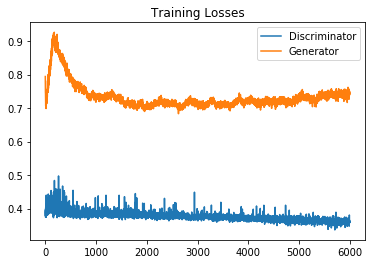

In [80]:
losses = np.array(gan.losses)

fig, ax = plt.subplots()
plt.plot([i[0][0] for i in losses], label='Discriminator')
plt.plot([i[1] for i in losses], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

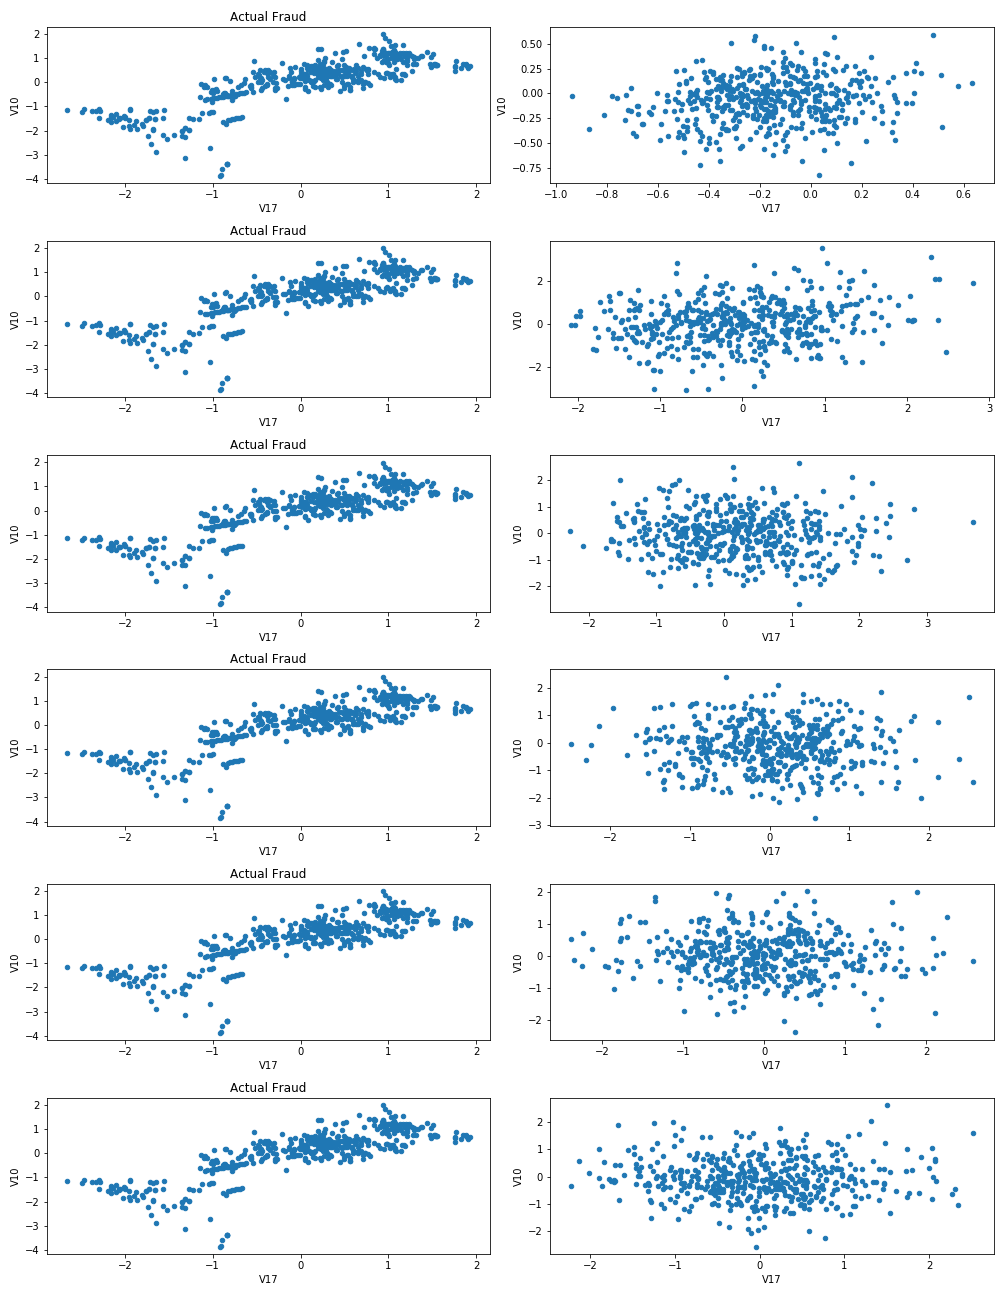

In [81]:
from IPython.display import Image
Image(filename='GANv1-ssl-v17-v10-img_2.png')

In [66]:
plt.figure()

In [15]:
plt.close()

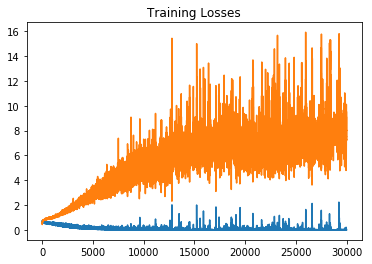

In [68]:
fig

In [50]:
test = pd.DataFrame([0,0,0,0,0,1,1,0], columns=['Class'])

In [58]:
indices = [i for i, x in enumerate(test.values) if x == 1]

In [59]:
indices

[5, 6]

In [85]:
gan

<__main__.GAN instance at 0x16543f1b8>

In [86]:
from keras.utils.vis_utils import plot_model
plot_model(gan.generator, to_file='ganv1-ssl-generator_plot.png', show_shapes=True, show_layer_names=True)


ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.